#This program is copy of 'MLSP_2019', need to re-run while writing ThaiJournal1

Ajarn Somsa Notes for me: For you, I'd like you to revise the previous conference paper to use the correct load lags (I called it the Revised Info Structure, but you don't need to call that. I just used that to easily refer to the change in the load lags) and to include the discussion on the performance for Sunday and/or Saturday, only holidays, and all-day dataset. That is the table before this section, Revision of Performance of Regression vs Feedforward Networks (28-29/5/19). I got that mape=2.62% for all days using separate models for different day types. I used different models for different day types.

This 2.62% MAPE is the benchmark we need to beat using LSTM or other DNN's.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy import polyfit
from dateutil.parser import parse
from datetime import datetime
from pandas.tseries.offsets import Week, Day, MonthEnd, WeekOfMonth, Hour, Minute
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
from keras import models
from keras import layers
import time
from keras import backend as K


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotgroups(groups):
    fa, fb = int(np.ceil(groups.ngroups/3)), 3
    fig, axes = plt.subplots(fa,fb,figsize=(15,3*fa), sharey=True, squeeze=False,)
    j = 0
    for name, group in groups:
        group.plot(ax=axes[np.floor_divide(j,fb), np.mod(j,fb)], grid=True)
        j = j + 1   
    plt.tight_layout()

Using TensorFlow backend.


In [2]:
data = pd.read_pickle(r'/Users/mac/Desktop/TUproject/analysis/MCC_data_pickle')
data.shape

(84816, 68)

Using Actual info structure 2019/05/16
In our previous study, when we talked about the 1-D lag load, we take the previous day load. However, in the real situation, forecasting by EGAT personale is done only on weekday and non-holiday. That means that, for example. the load at HH=20 on Monday is done by using the 1D lag load which is the load at HH=20 on Friday. In addtion, if HH=30 (after 28), then the 1D lag load is the load at HH=30 on Thur.

So we call this situation where we use the actual information structure as the Actual Info Structure case. I hope that this would give better perforamnce for the non-holiday, non-weekend case. Let's see now.

I have revised the Actual Info Structure where we still take the latest working day for HH before 28, but for HH > 28, we use the day before the latest working day.

I have created a new variable called load1D_cut2pm_RRR to be used in place of load1D_cut2pm_RR which incorrectly takes the previous latest working day.

For example, if today is Tue. For HH<= 28, the load in the prev day is that on Monday but for HH>28, the load in the prev day should be the load on Sunday (load1D_cut2pm_RRR does this), not Friday (load1D_cut2pm_RR does this).

In [3]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekdays
df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 4)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

Sizes: train=936, test=246

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.22


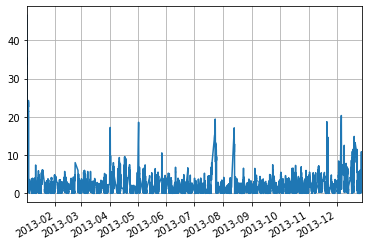

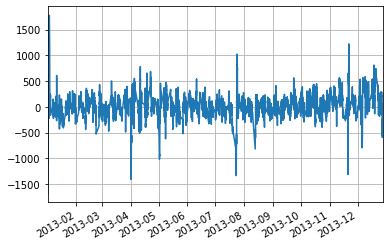

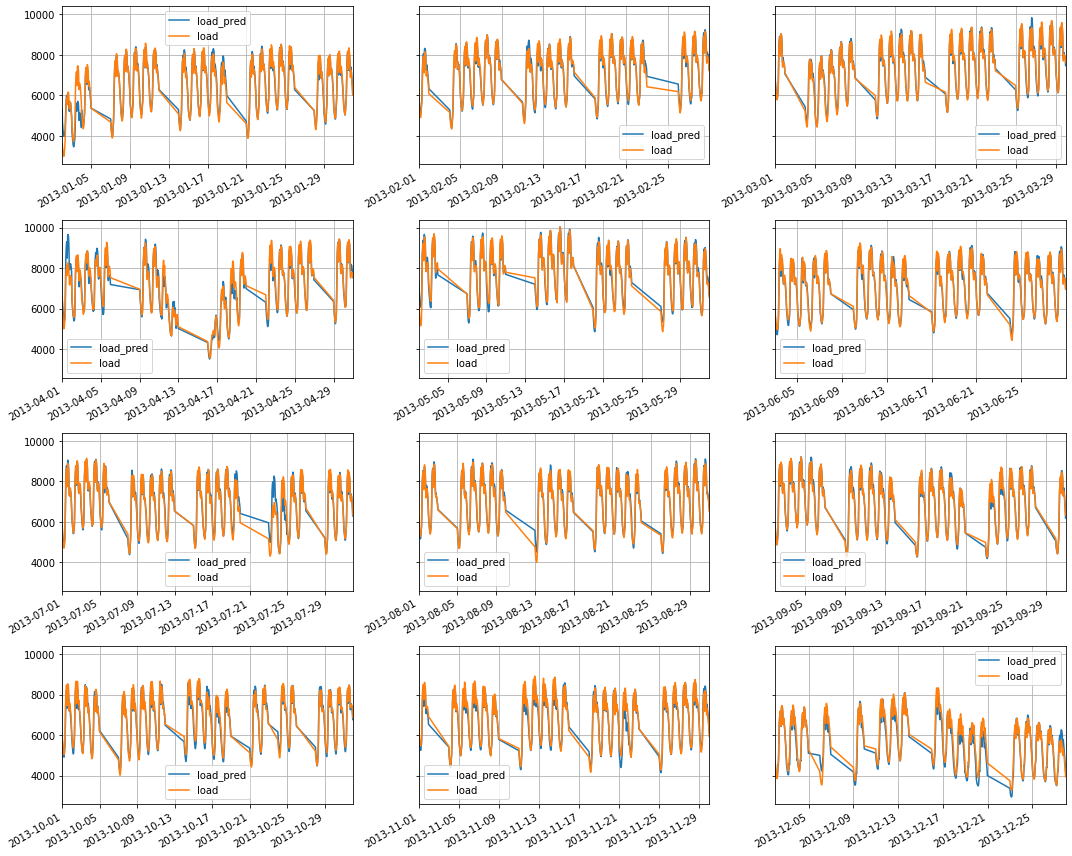

In [4]:
from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))


In [5]:
def plotgroups(groups):
    fa, fb = int(np.ceil(groups.ngroups/3)), 3
    fig, axes = plt.subplots(fa,fb,figsize=(15,3*fa), sharey=True, squeeze=False,)
    j = 0
    
    for name, group in groups:
        group.plot(ax=axes[np.floor_divide(j,fb), np.mod(j,fb)], grid=True)
        j = j + 1 
        plt.ylim(0,9500)

    plt.tight_layout()

<Figure size 1440x1152 with 0 Axes>

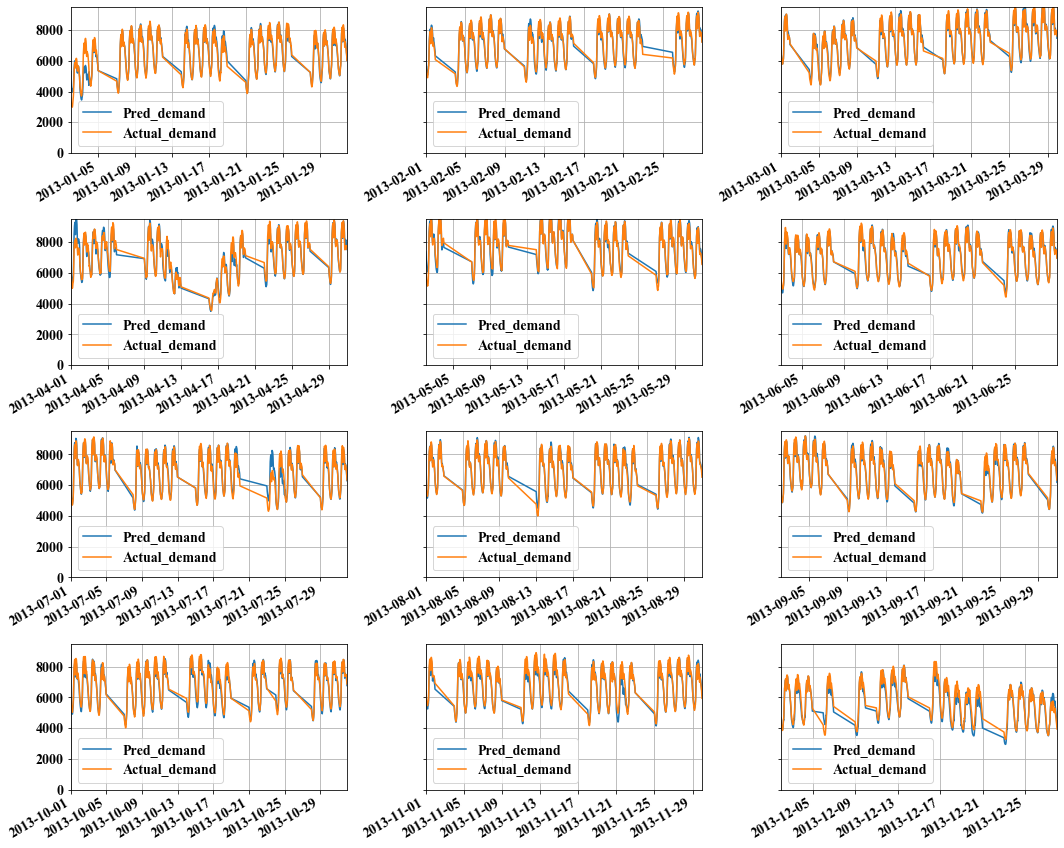

In [6]:
#converting the load columns into 'Actual_demand' and 'load_pred' into 'Pred_demand'
#print("Your income tax is ${:,}".format(income))
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dff=df.filter(['load','load_pred'])
dff=dff.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
plotgroups(dff.loc[test_end,['Pred_demand','Actual_demand']].resample('M'))    
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/OLSforecastScenario1.eps', format='eps', dpi=400)

In [7]:
#For beta variables
true_model_param_names=X0.design_info.column_names
Estimated_model_params=pd.DataFrame(OutsideList,columns=true_model_param_names)
Estimated_model_params.index.name = 'HH'
#Estimated_model_params.to_csv(r'/Users/mac/Desktop/TUproject/Results/OLS_WeekdaysCoeffMean.csv')  #Storing mean coeff


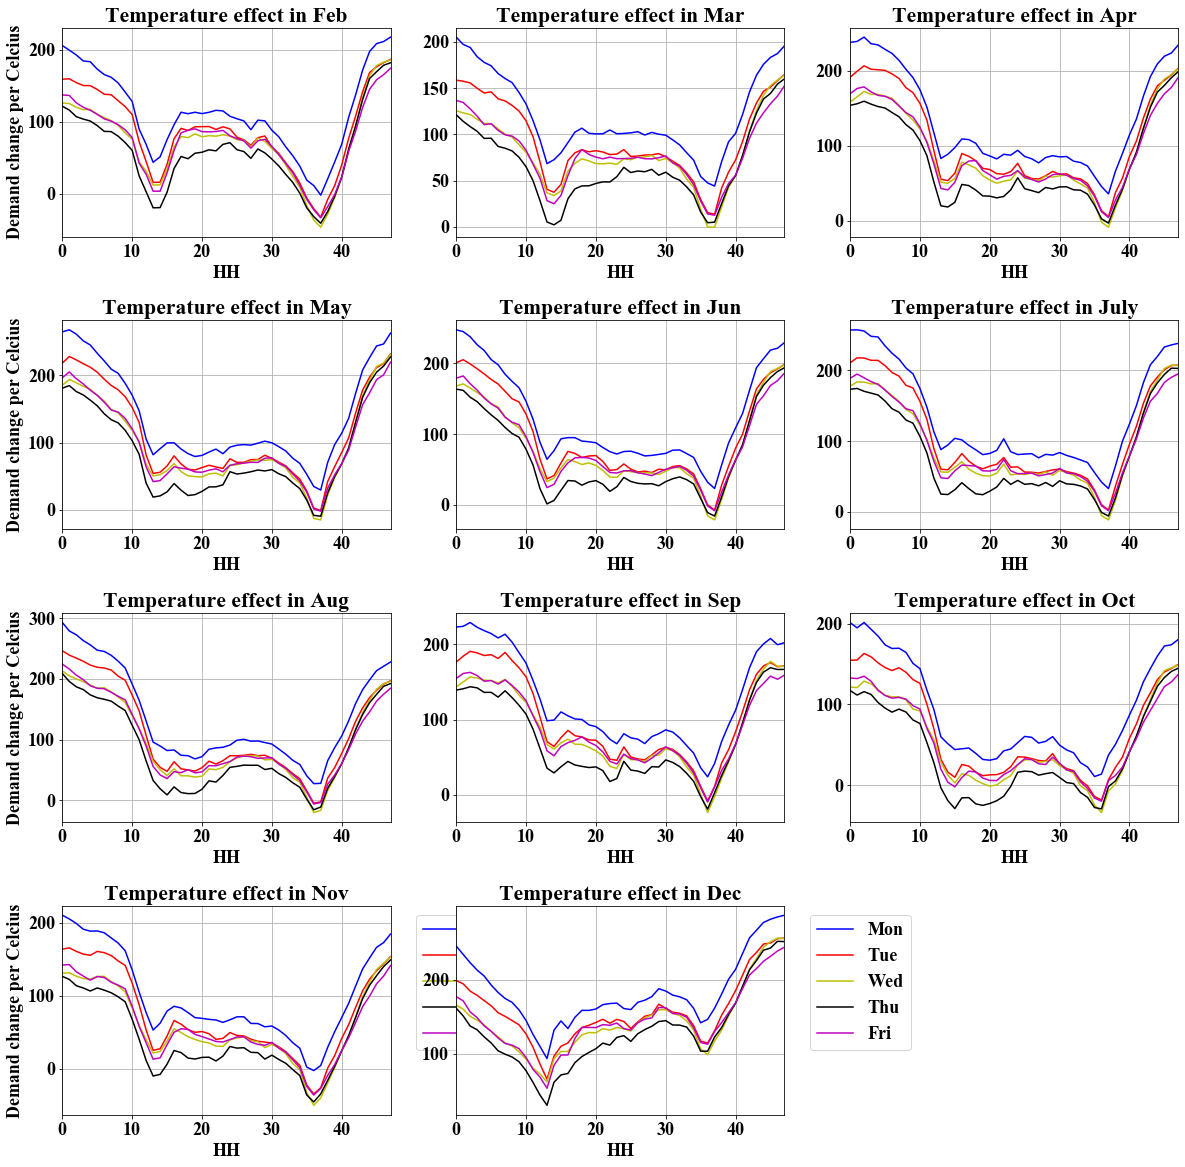

In [8]:
def TempEffect():
    plt.rcParams.update({'font.size': 18})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
    Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for ii in range(11):
        month0=Monthtypes[ii]
        monthTD = 'MD[T.' + month0 + ']:temp' #month and temp dummy
        MaxT='MaxTemp'
        MaxTYestDay='MaxTempYesterday'
        MA2pmT='MA2pmTemp'
        #Tmp='temp'
        
        #'WD[Mon]:temp'
        for d in daytypes:
            p[d] = p['WD[' + d +']:temp'] + p[monthTD] \
            +p[MaxT]+p[MaxTYestDay]+p[MA2pmT]#+p[Tmp]

        plt.rcParams["font.family"] = "Times New Roman"
        chrt+=1
        ax=fig1.add_subplot(4,3,chrt)
        p.loc[:,'Mon':'Fri'].plot(style=styles,grid=True,\
                                  title='Temperature effect in %s' % month0,ax=ax)
        
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        fig1.subplots_adjust(hspace=0.4)
        if chrt<=9:
            ax.get_legend().remove()
        if chrt%3==1:
            plt.ylabel('Demand change per Celcius')
    
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

TempEffect()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChangeAllPlots.eps', format='eps')


<Figure size 864x576 with 0 Axes>

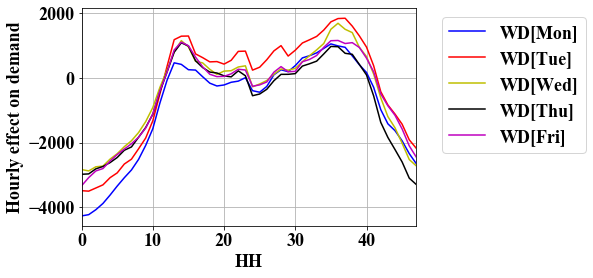

In [9]:
#For Daytype effect,
p = Estimated_model_params
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 18})

styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
plt.rcParams["font.family"] = "Times New Roman"

ax = p.loc[:,'WD[Mon]':'WD[Fri]'].plot(style=styles,grid=True)
ax.set_ylabel('Hourly effect on demand')
ax.legend(bbox_to_anchor=(1.05, 1.0))
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChangeDaywise.eps', format='eps')


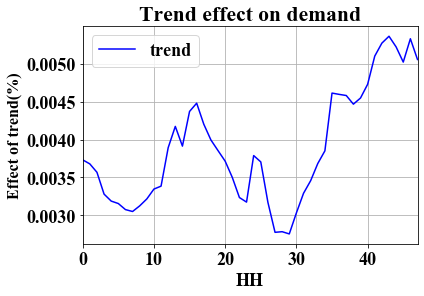

In [10]:
p = Estimated_model_params

styles=['b-','r-','r-.','y-.','b:','r:','y:','k:']
p.loc[:,'trend'].plot(style=styles,grid=True,\
                                                    title='Trend effect on demand')
plt.rcParams["font.family"] = "Times New Roman"
plt.ylabel('Effect of trend(%)',size=16)
plt.legend(loc=2,ncol=3)

#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/OlsDemandChangeAllPlots.eps', format='eps')


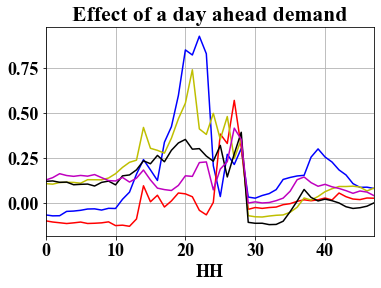

In [11]:
def load1d_cut2pmEffect():
    plt.rcParams.update({'font.size': 18})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
   # Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for d in daytypes:
        p[d] = 'MD[' + d + ']:load1D_cut2pm_RRR' #month and temp dummy
    
    plt.rcParams["font.family"] = "Times New Roman"
    chrt+=1
    ax=fig1.add_subplot(4,3,chrt)
    p.loc[:,'WD[Mon]:load1D_cut2pm_RRR':'WD[Fri]:load1D_cut2pm_RRR'].plot(style=styles,grid=True,\
                              title='Effect of a day ahead demand',ax=ax)
        
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    fig1.subplots_adjust(hspace=0.4)
    if chrt<=9:
        ax.get_legend().remove()
    if chrt%3==0:
        plt.ylabel('Load change per Celcius')
        
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

load1d_cut2pmEffect()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChangeDayaheadDemand.eps', format='eps')


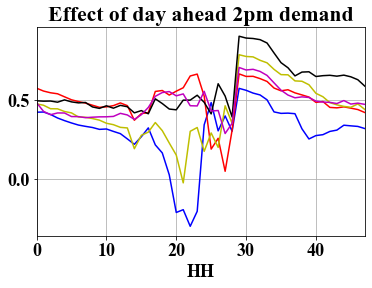

In [12]:
def Load2pmYesterday():
    plt.rcParams.update({'font.size': 18})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
   # Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for d in daytypes:
        p[d] = 'MD[' + d + ']:Load2pmYesterday_RR' #month and temp dummy
    
    plt.rcParams["font.family"] = "Times New Roman"
    chrt+=1
    ax=fig1.add_subplot(4,3,chrt)
    p.loc[:,'WD[Mon]:Load2pmYesterday_RR':'WD[Fri]:Load2pmYesterday_RR'].plot(style=styles,grid=True,\
                              title='Effect of day ahead 2pm demand',ax=ax)
        
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    fig1.subplots_adjust(hspace=0.4)
    if chrt<=9:
        ax.get_legend().remove()
    if chrt%3==0:
        plt.ylabel('Load change per Celcius')
    
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

Load2pmYesterday()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChange2pmYesterday.eps', format='eps')


This scenario (Mon-Fri) gives MAPE of 2.22%

# Let's now try forecasting weekend, using the revised Actual Info Structure

Sizes: train=381, test=101

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.53


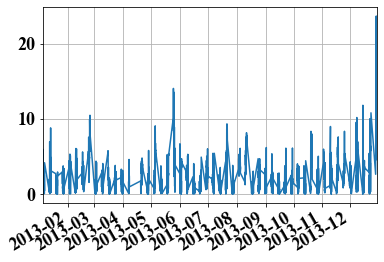

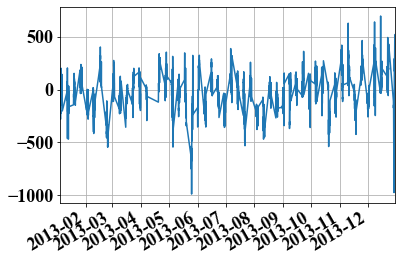

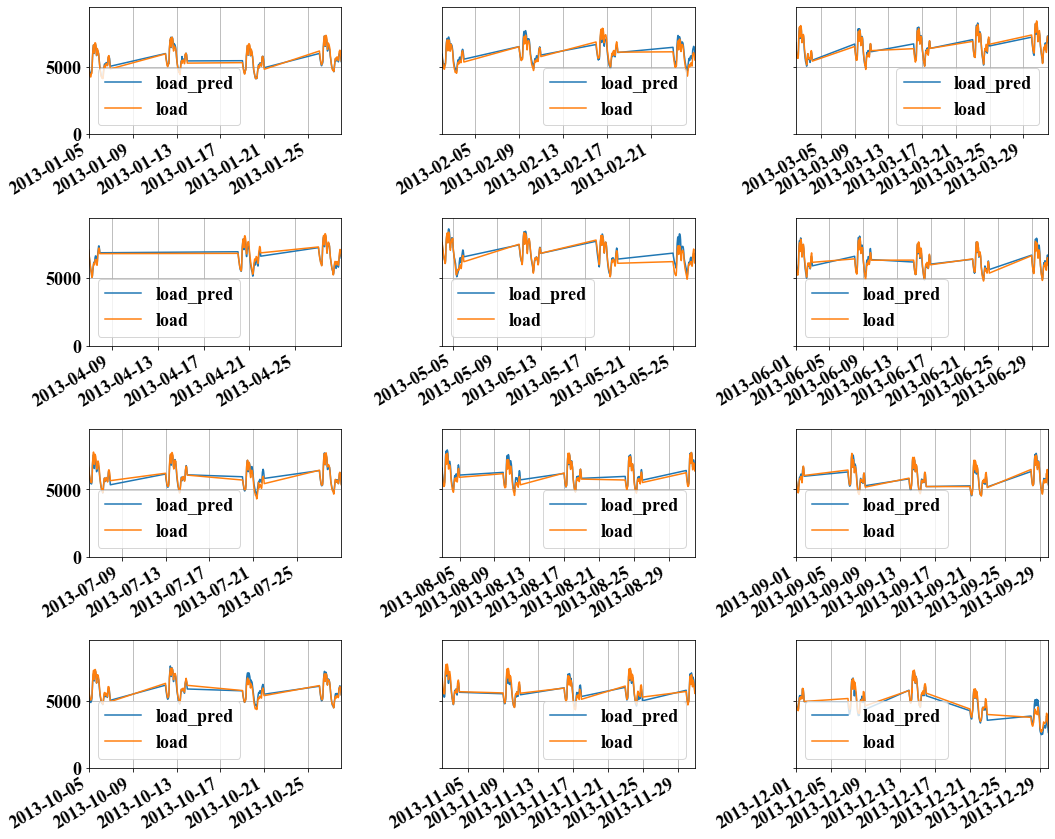

In [13]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 5) & (df.Weekday <= 6)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))

# Forecasting for Saturday only

Sizes: train=190, test=50

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.30


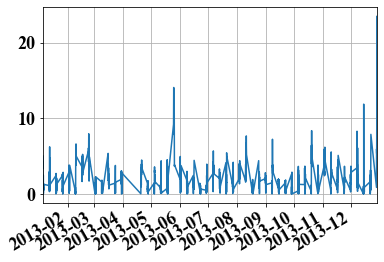

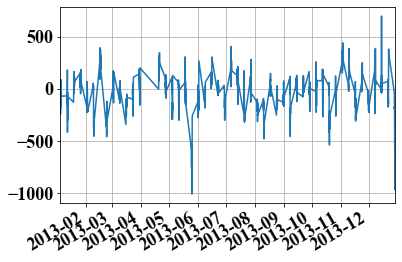

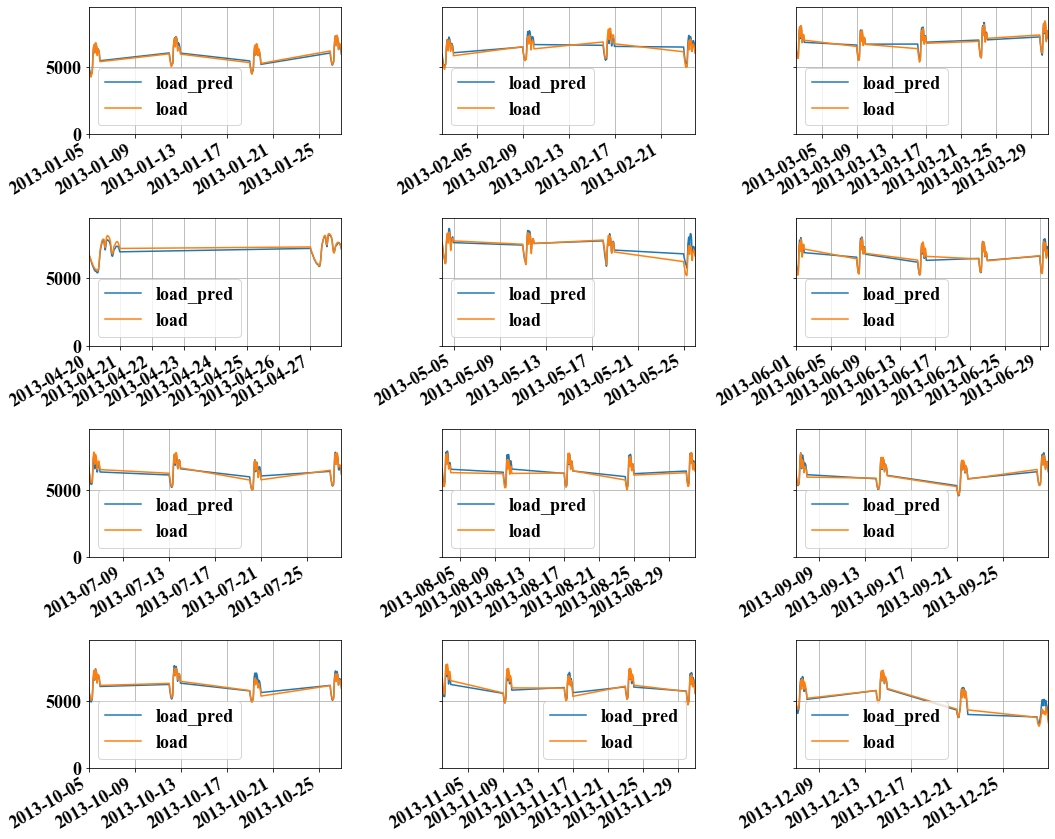

In [14]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 5) & (df.Weekday <= 5)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))


Sizes: train=191, test=51

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.74


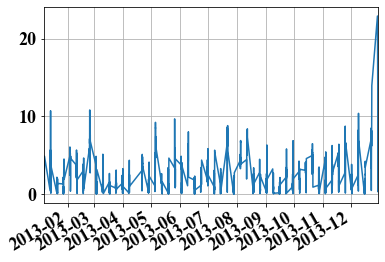

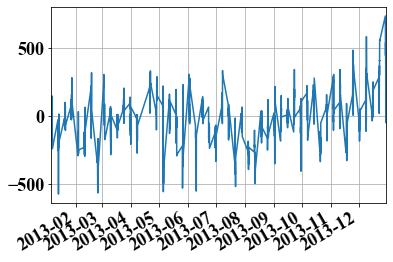

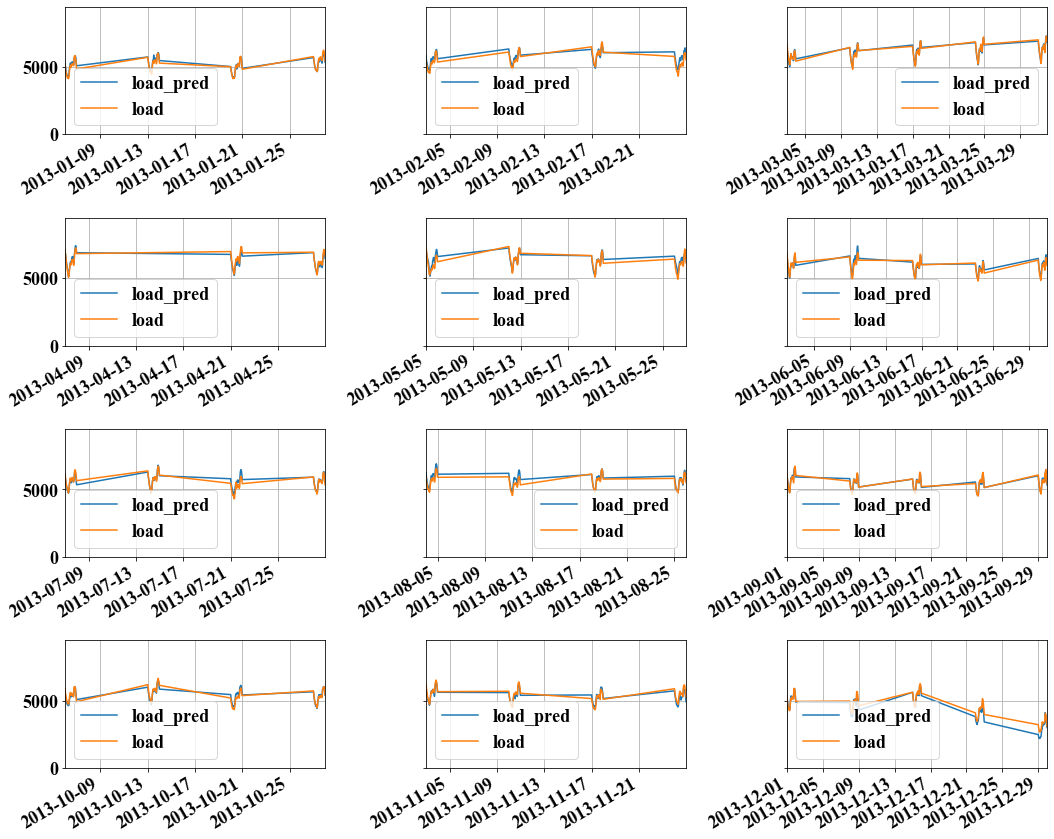

In [15]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 6) & (df.Weekday <= 6)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))


<Figure size 1440x1152 with 0 Axes>

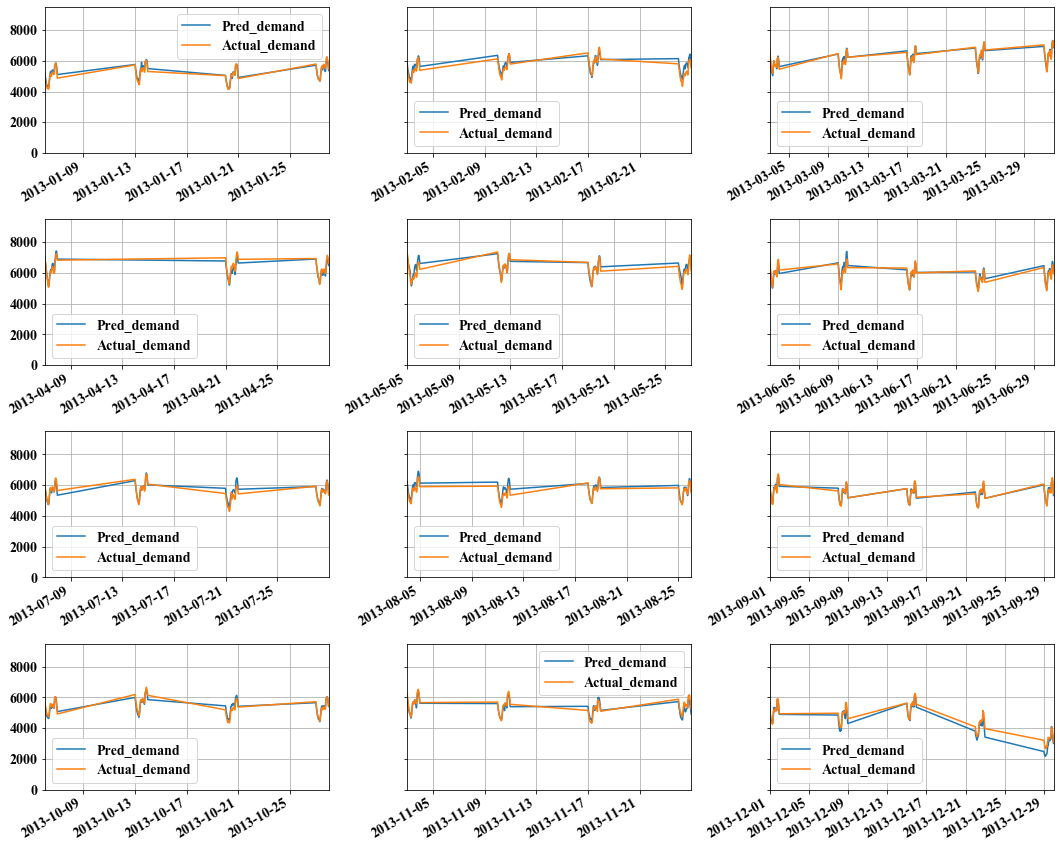

In [16]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
plotgroups(dfPlot.loc[test_end,['Pred_demand','Actual_demand']].resample('M'))  

### In summary, for the weekends,

| Models | MAPE | No. Test Samples |
| - | - | - |
| 1. Sat - Sun | 2.09 | 87 | 
| 2. Sat | 1.87 | 44 |
| 3. Sun | 2.31 | 43 |
| avg of Models 2 and 3 | 2.09 | |

(Ajarn's result) 

Since the average of the MAPEs from the separate models 2 and 3 is similar to that of Model 1, it's a bit better to predict Saturdays and Sundays seperately. We get the avg MAPE of 2.52%. 

Note: It's interesting to see the MAPE only for Sundays (not Saturdays) when we use Model 1. It might be that to predict Sat loads we use model 2 but to predict Sun loads we use model 1.

# Let's see the performance of seperating weekdays as well, for example, doing Mondays alone.

Sizes: train=180, test=44

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.61


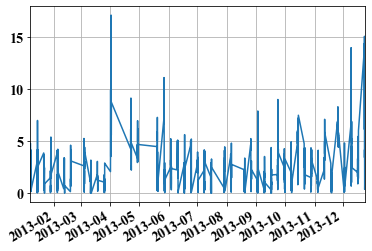

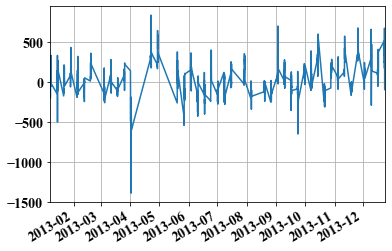

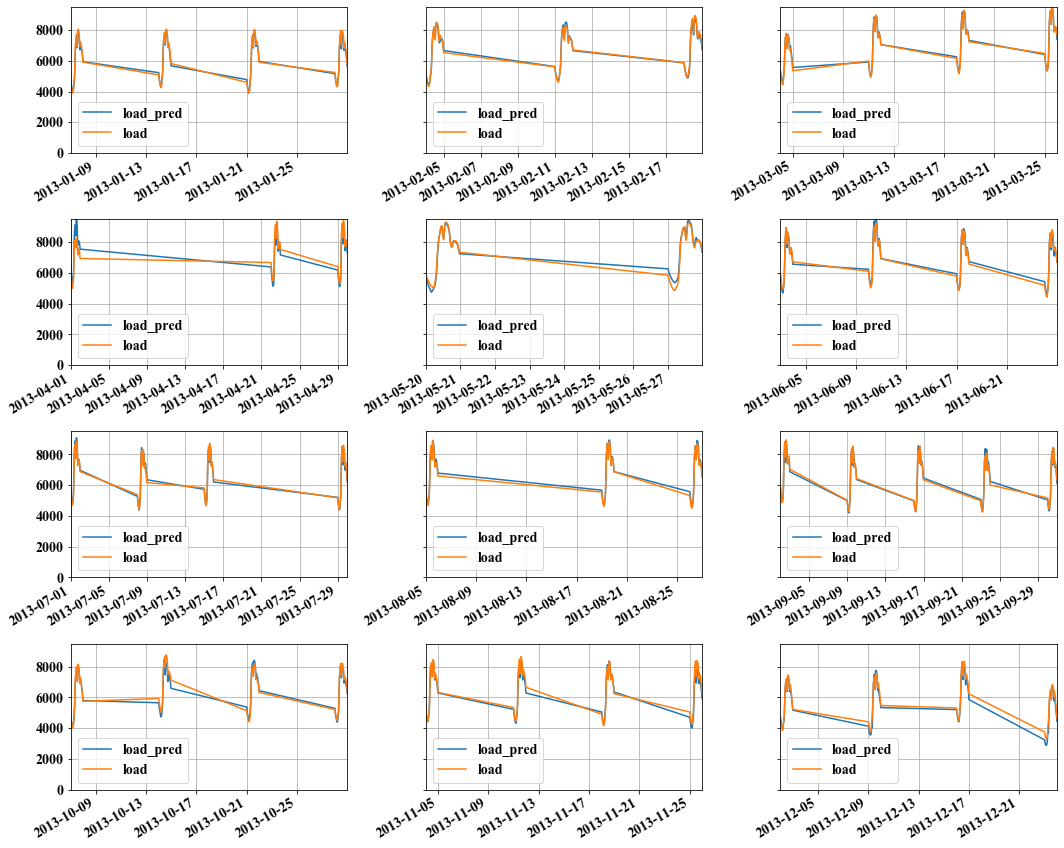

In [17]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 0)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))

Monday alone performance is worse (2.78%)

Sizes: train=756, test=202

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.23


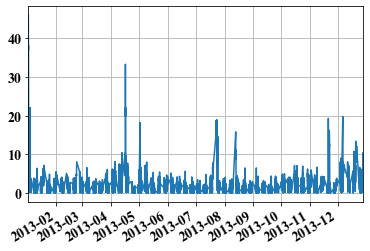

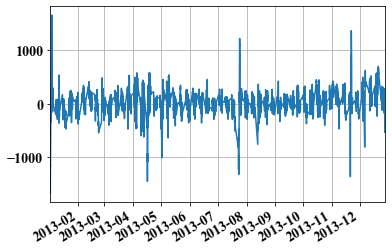

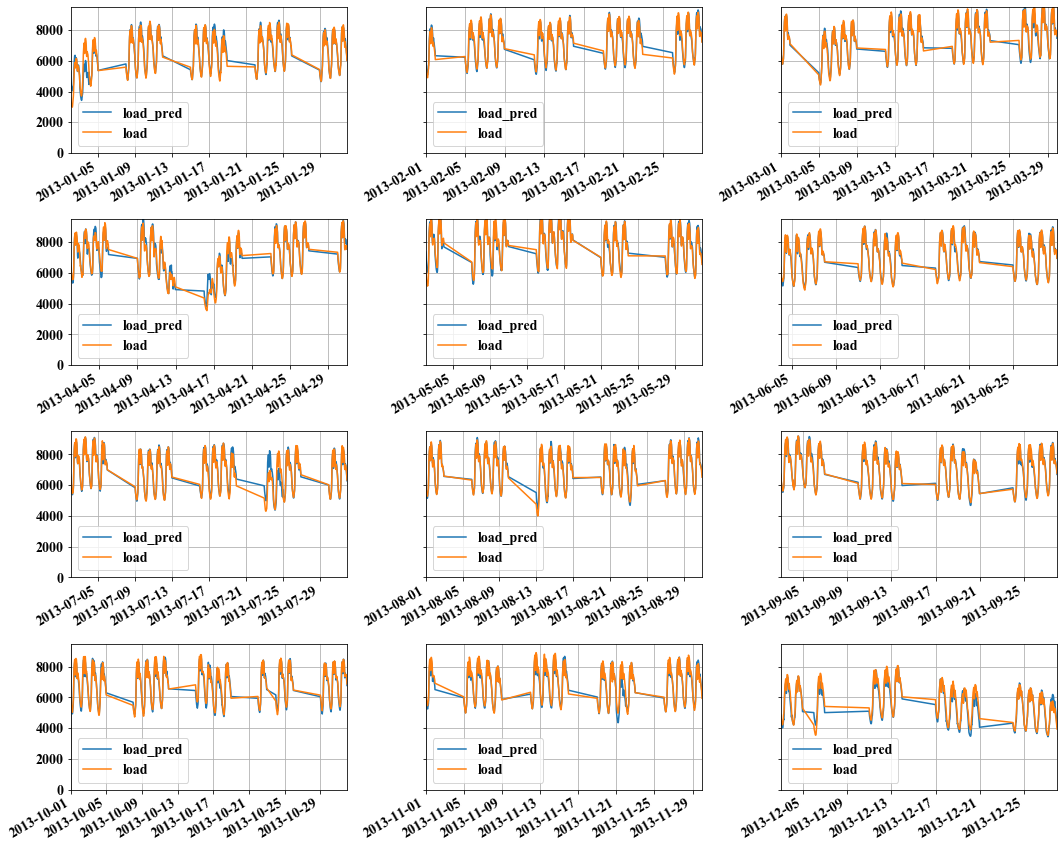

In [18]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 1) & (df.Weekday <= 4)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))

In summary, for the non-holiday weekdays,

| Models | MAPE | No. Test Samples |
| - | - | - |
| 1. Mon - Fri | 2.22 | 245 | 
| 2. Mon | 2.78 | 44 |
| 3. Tue - Fri | 2.11 | 201 |
| Avg of Models 2 and 3  | 2.44 | |

Since Model 1 is the best, it's better to predict Mon - Fri together in a single model. Since Monday depends on the load from Friday, it may not be so surprising to see worse performance on Monday, compared to other weekdays and even compared with Sat or Sun.

# Let's predict all non-holidays together.

Sizes: train=1317, test=347

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 2.27


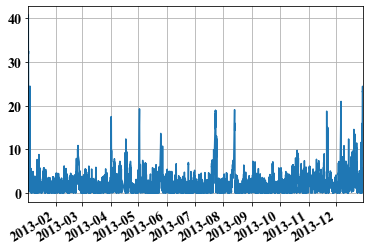

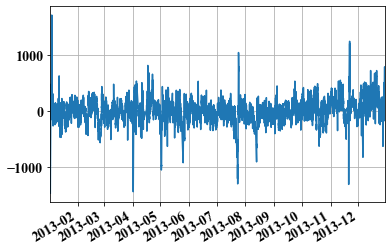

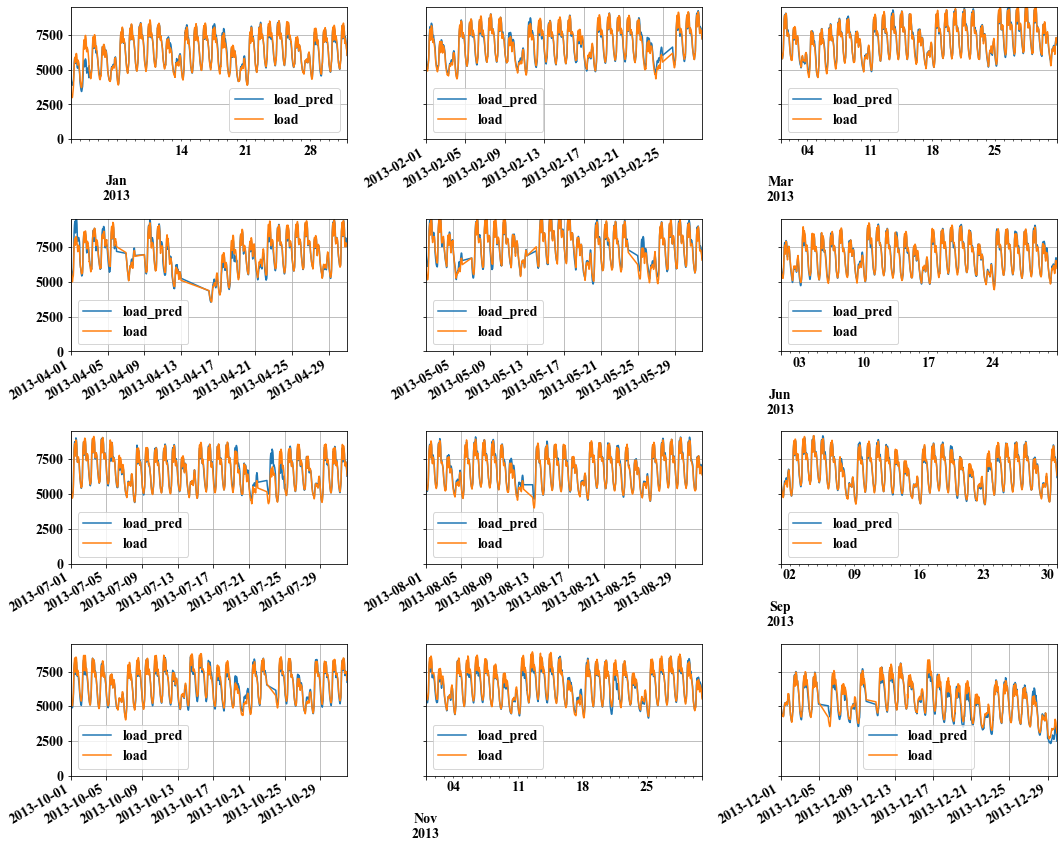

In [19]:
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekends
df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 6)&(df.Holiday==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday
pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))

In summary, for non-holidays, we applied the same model to seperate sets of data. 

| Models | MAPE | No. Test Day Samples |
| - | - | - |
| 1. Sat - Sun | 2.09 | 87 | 
| 1a. Sat | 1.87 | 44 |
| 1b. Sun | 2.31 | 43 |
| Avg of 1a and 1b | 2.09 | |
| 2. Mon - Fri | 2.22 | 245 | 
| 2a. Mon | 2.78 | 44 |
| 2b. Tue - Fri | 2.11 | 176 |
| Avg of 2a and 2b  | 2.44 | |
| 3. Mon-Sun | 2.14 | 326 |

# Forecasting Holidays

get details results from egat_DNN_190528

# Ultimate dataset which includes all days and holidays

Sizes: train=1395, test=365

HH=0, t=
HH=1, t=
HH=2, t=
HH=3, t=
HH=4, t=
HH=5, t=
HH=6, t=
HH=7, t=
HH=8, t=
HH=9, t=
HH=10, t=
HH=11, t=
HH=12, t=
HH=13, t=
HH=14, t=
HH=15, t=
HH=16, t=
HH=17, t=
HH=18, t=
HH=19, t=
HH=20, t=
HH=21, t=
HH=22, t=
HH=23, t=
HH=24, t=
HH=25, t=
HH=26, t=
HH=27, t=
HH=28, t=
HH=29, t=
HH=30, t=
HH=31, t=
HH=32, t=
HH=33, t=
HH=34, t=
HH=35, t=
HH=36, t=
HH=37, t=
HH=38, t=
HH=39, t=
HH=40, t=
HH=41, t=
HH=42, t=
HH=43, t=
HH=44, t=
HH=45, t=
HH=46, t=
HH=47, t=MAPE over all halfhours in 2013 = 3.00


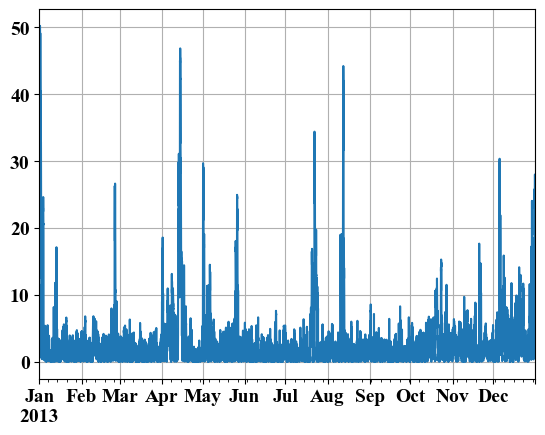

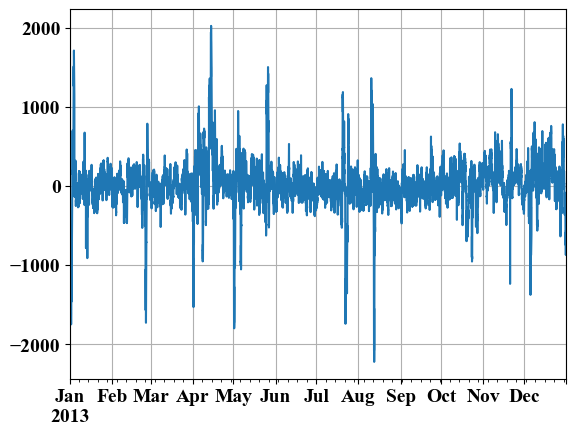

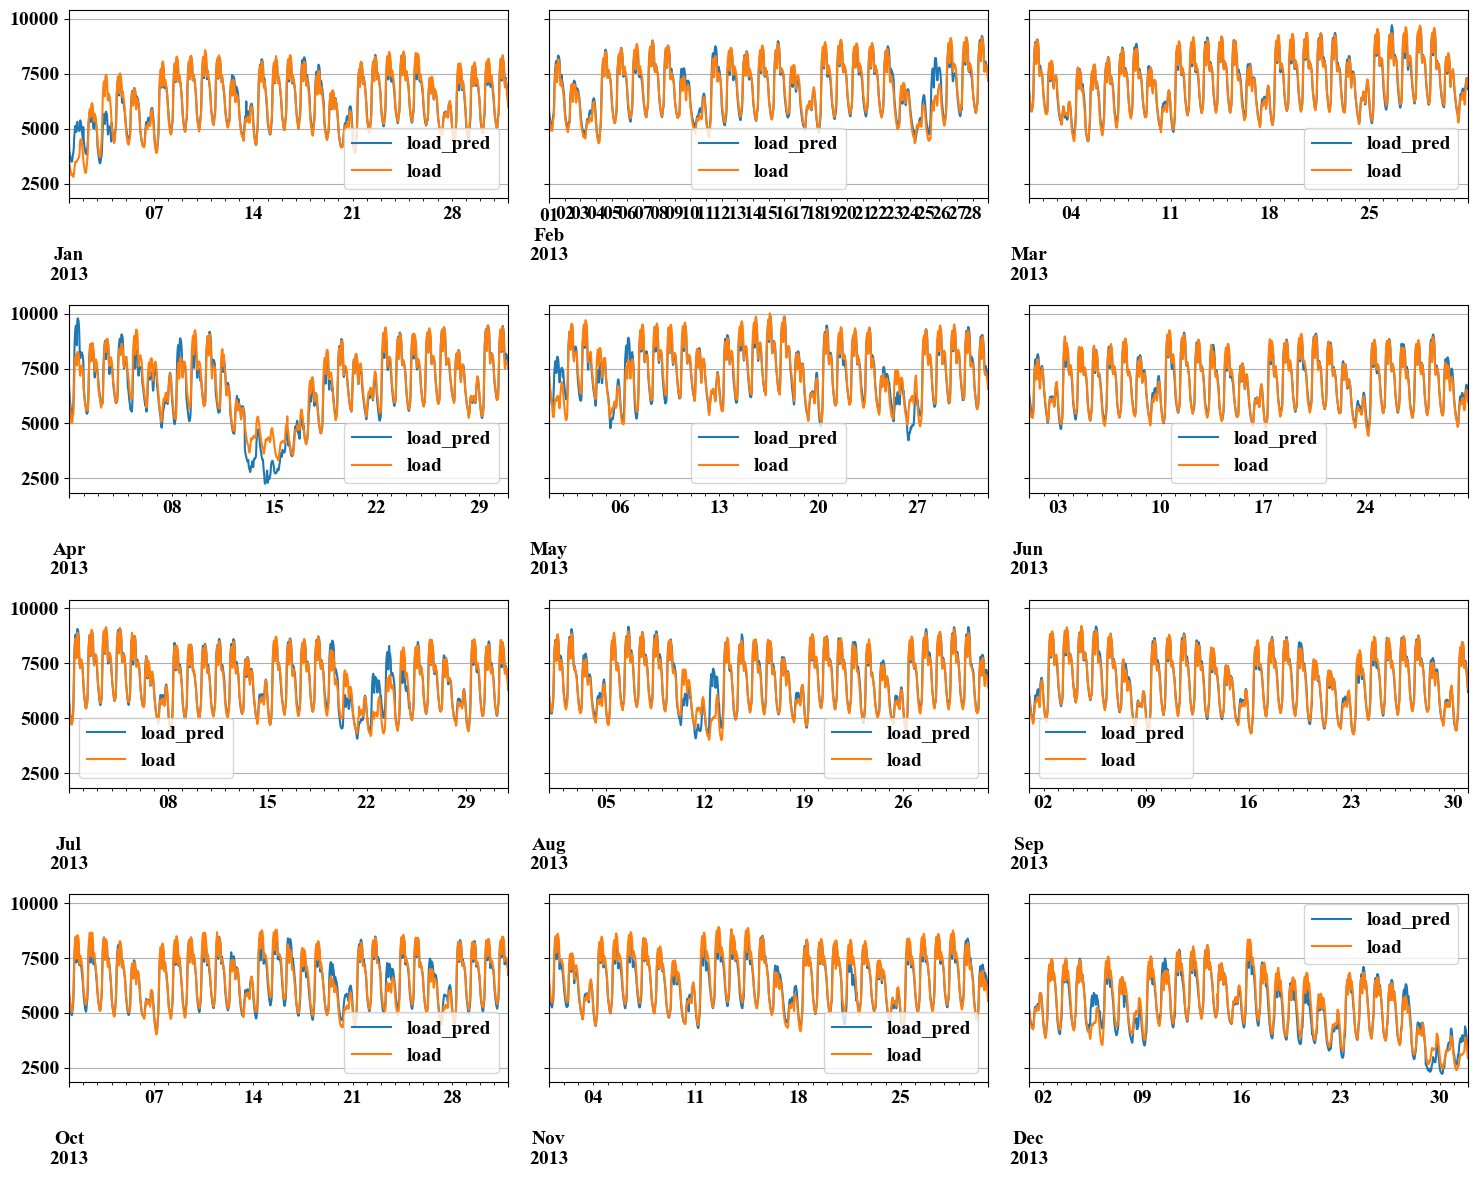

In [102]:
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = data[train_start:test_end].copy()

from numpy import array

## This is the old ARMAX model
# model_str_ARMAX = 'load ~ trend + load1d_cut2pm_ + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + WD:np.square(temp)\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

# This is the new one. I've remove the term, e.g., load1d_cut2pm since it is already taken care of by 
# WD:load1D_cut2pm_RRR. I added the term '-1' so that now the weekday dummies WD show Mon to Sun (before 
# it shows only Tue to Sun since we already have a constant term.
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR '
# + Songkran1D:load1D_cut2pm_RRR + Songkran2D:load1D_cut2pm_RRR \
# + Newyear1D:load1D_cut2pm_RRR + Newyear2D:load1D_cut2pm_RRR'


model_str=model_str_ARMAX_nonholiday

#and model for holiday is,
model_str_ARMAX_holiday='load ~ trend + MaxTemp + MaxTempYesterday + MA2pmTemp + WD - 1\
+ temp + Asalha + Chakri + Chulalongkorn + Constitution + Coronation + King + Labor \
+ Lent + Makha + Newyear + Ploughing + Queen + Songkran + Visakha'

model_str='load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR \
+ Asalha + Chakri + Chulalongkorn + Constitution + Coronation + King + Labor \
+ Lent + Makha + Newyear + Ploughing + Queen + Songkran + Visakha'

pred_intervals=0
OLS=True
rho=1
printhh=False


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)

T = 48
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

if (pred_intervals <= 0):
    pred_intervals = test_size
    # the prediction length for each prediction interval
pred_len = int(np.ceil(test_size/pred_intervals))
    
df['load_pred'] = 0

for hh in range(T):
    InsideList=list()
    print('')
    print('HH=%d, t=' % hh, end = '')
    yhat_all = []
        
    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(pred_intervals):
        #print('%d,' % t, end = '')
        hh_train_start = t*pred_len
        hh_train_end = hh_train_start + train_size
        hh_test_start = hh_train_end
        if (t < (pred_intervals - 1)):
            hh_test_end = hh_test_start + pred_len
        else:
            hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#           ytrain = y[hh_train_start:hh_train_end]
#           Xtrain = X[hh_train_start:hh_train_end]
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test_start:hh_test_end]
        Xtest = X[hh_test_start:hh_test_end]
                
        if (OLS):
             # OLS 
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)
        else:
            ## GLSAR with the number of lags in the noise process is rho
            model = sm.GLSAR(ytrain, Xtrain, rho)
            model_fit = model.iterative_fit(6)

        output = model_fit.predict(Xtest)
        yhat = output
        yhat_all = np.concatenate((yhat_all,yhat))
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length

            
    if (printhh):
        print('hh=%d' % hh)
        print((model_fit.summary()))                
        
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
    
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

        
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()
plt.grid()
plt.figure()
df.loc[test_end,'resid'].plot()
plt.grid()
    
plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))

<Figure size 1440x1152 with 0 Axes>

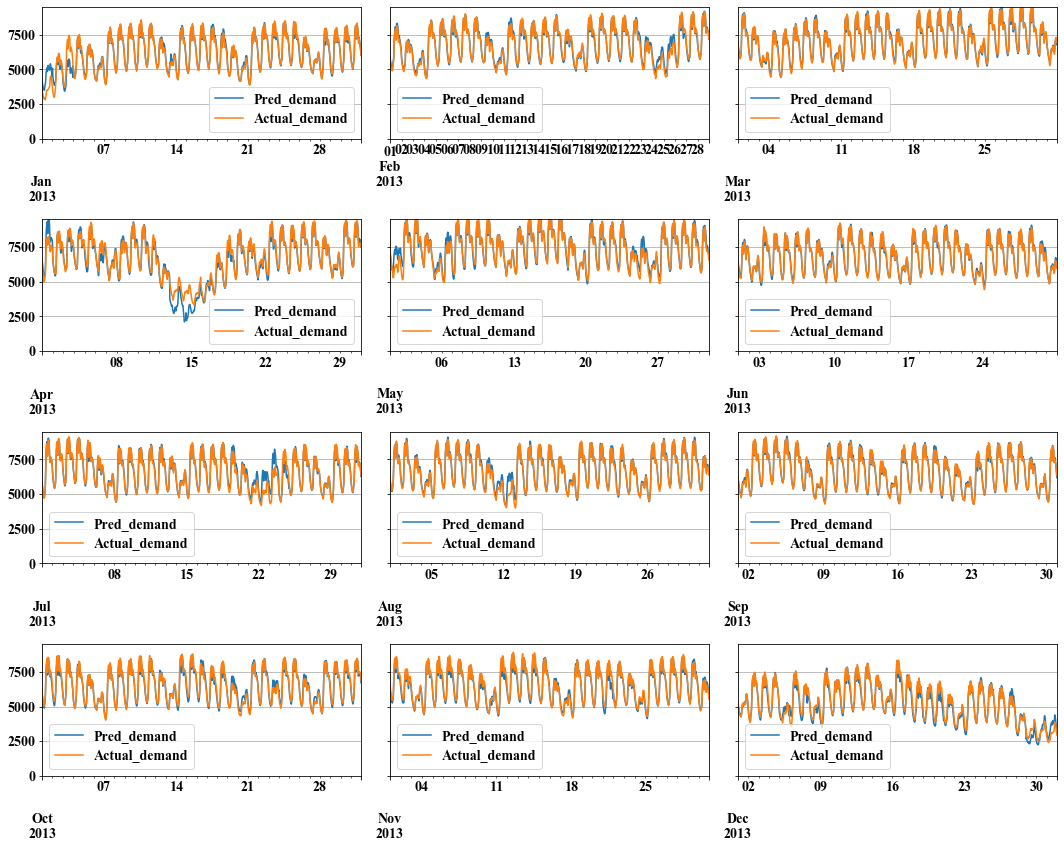

In [21]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
plotgroups(dfPlot.loc[test_end,['Pred_demand','Actual_demand']].resample('M'))  

<Figure size 1440x1152 with 0 Axes>

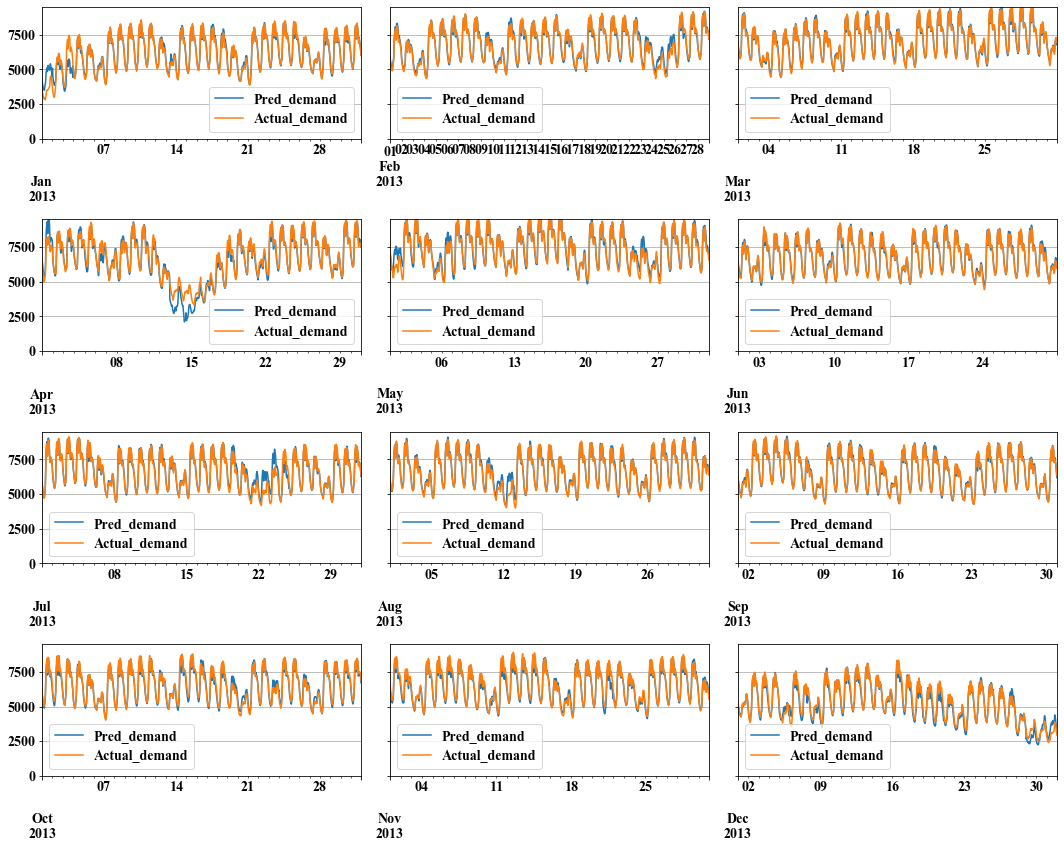

In [22]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dff=df.filter(['load','load_pred'])
dff=dff.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
plotgroups(dff.loc[test_end,['Pred_demand','Actual_demand']].resample('M'))    
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/OLSforecastScenario444.eps', format='eps', dpi=400)

<Figure size 2000x1600 with 0 Axes>

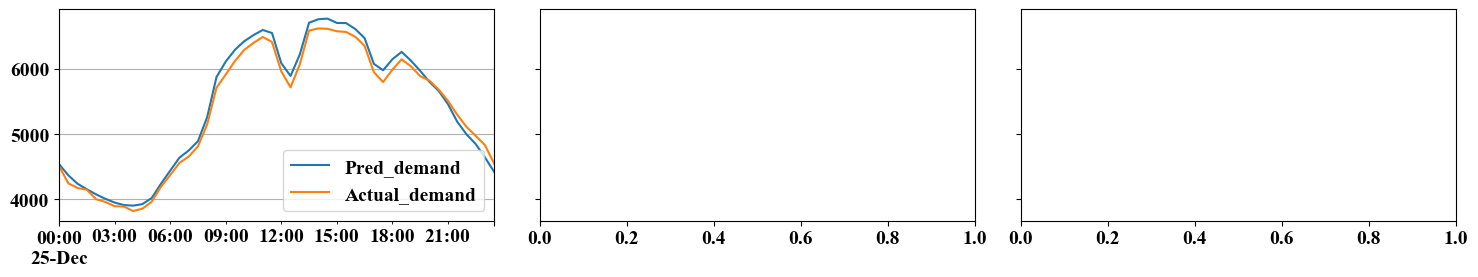

In [104]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
plotgroups(dfPlot.loc['2013-12-25':'2013-12-25',['Pred_demand','Actual_demand']].resample('D')) 


<Figure size 1440x1152 with 0 Axes>

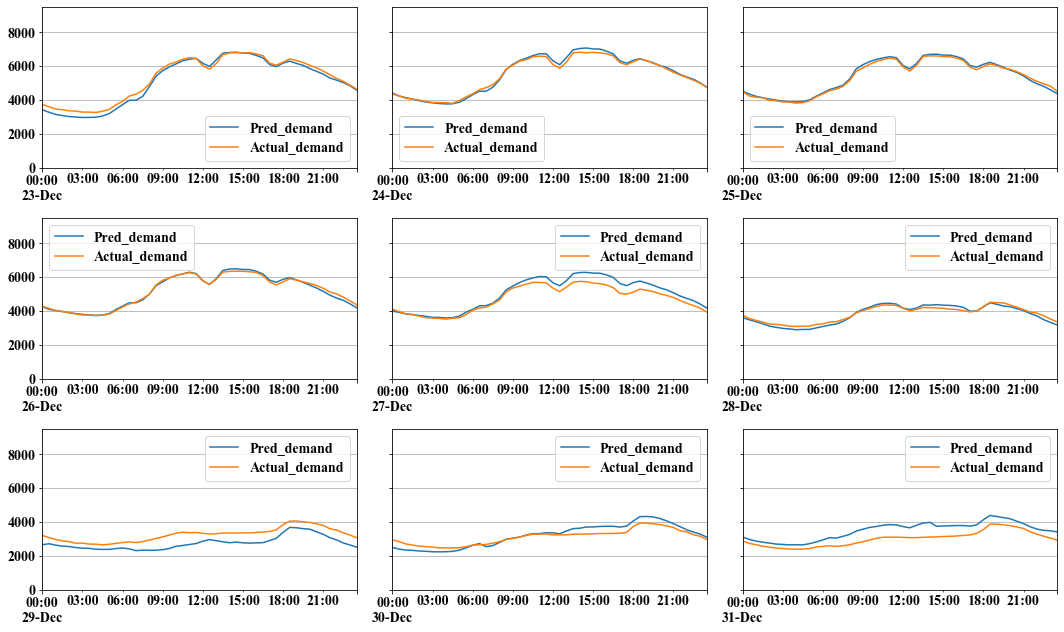

In [23]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
plotgroups(dfPlot.loc['2013-12-23':'2013-12-31',['Pred_demand','Actual_demand']].resample('D')) 

# plt.rcParams.update({'font.size': 16})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# dfThesis.loc['2013-12-24':'2013-12-31','Demand'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()

<Figure size 1440x1152 with 0 Axes>

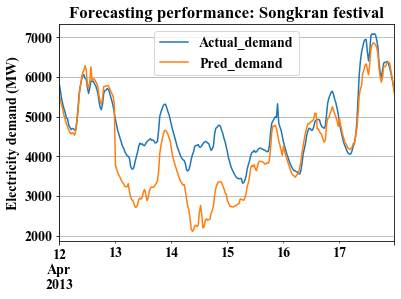

In [24]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
#plotgroups(dfPlot.loc['2013-12-23':'2013-12-31',['Pred_demand','Actual_demand']].resample('D')) 


dfPlot.loc['2013-04-12':'2013-04-17',['Actual_demand','Pred_demand']].plot(title='Forecasting performance: Songkran festival')
plt.ylabel('Electricity demand (MW)')
plt.grid(True)

/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


<Figure size 2000x1600 with 0 Axes>

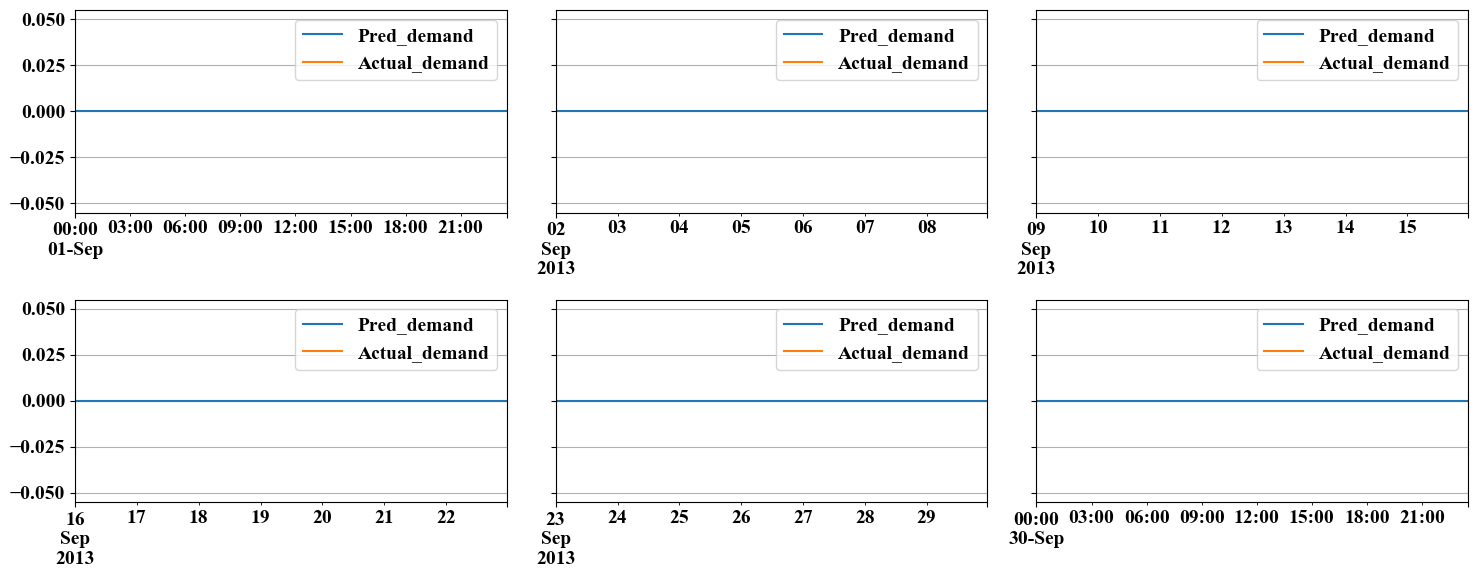

In [101]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
#plotgroups(dfPlot.loc['2013-12-23':'2013-12-31',['Pred_demand','Actual_demand']].resample('D')) 

plotgroups(dfPlot.loc['2013-09-1':'2013-9-30',['Pred_demand','Actual_demand']].resample('W')) 

# dfPlot.loc['2013-09-1':'2013-9-30',['Actual_demand','Pred_demand']].plot(title='Forecasting performance: Sep 2013')
# plt.ylabel('Electricity demand (MW)')
# plt.grid(True)
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/Scenario4SeptForecast.eps', format='eps', dpi=400)

/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


<Figure size 2000x1600 with 0 Axes>

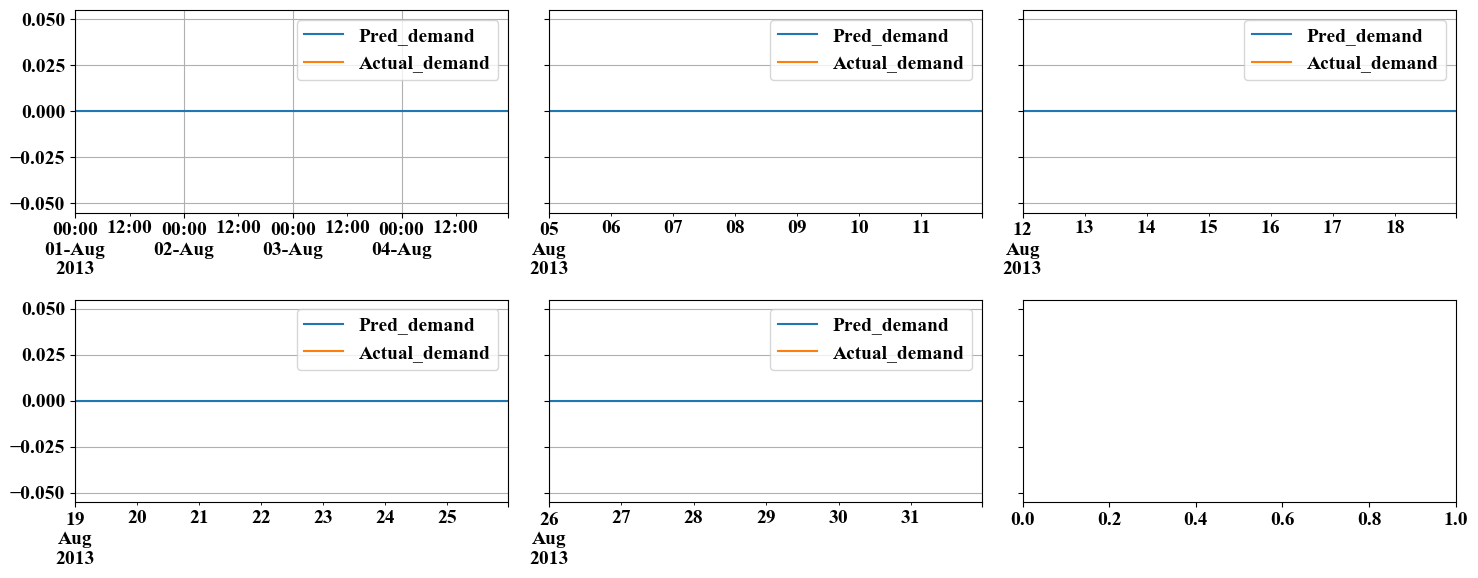

In [100]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
#plotgroups(dfPlot.loc['2013-12-23':'2013-12-31',['Pred_demand','Actual_demand']].resample('D')) 

plotgroups(dfPlot.loc['2013-08-1':'2013-8-31',['Pred_demand','Actual_demand']].resample('W')) 


<Figure size 1440x1152 with 0 Axes>

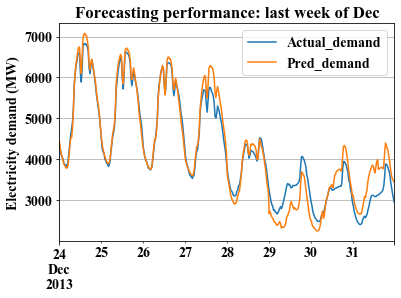

In [26]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
dfPlot=df.filter(['load','load_pred'])
dfPlot=dfPlot.rename(columns={"load":"Actual_demand", "load_pred":"Pred_demand"})
#dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Intraday electrcity demand profile')
#plotgroups(dfPlot.loc['2013-12-23':'2013-12-31',['Pred_demand','Actual_demand']].resample('D')) 


dfPlot.loc['2013-12-24':'2013-12-31',['Actual_demand','Pred_demand']].plot(title='Forecasting performance: last week of Dec')
plt.ylabel('Electricity demand (MW)')
plt.grid(True)

# Now Detail analysis for Ultimate model

In [27]:
#For beta variables
true_model_param_names=X0.design_info.column_names
Estimated_model_params=pd.DataFrame(OutsideList,columns=true_model_param_names)
Estimated_model_params.index.name = 'HH'
#Estimated_model_params.to_csv(r'/Users/mac/Desktop/TUproject/Results/OLS_WeekdaysCoeffMean.csv')  #Storing mean coeff


In [28]:
Estimated_model_params.columns

Index(['WD[Mon]', 'WD[Tue]', 'WD[Wed]', 'WD[Thu]', 'WD[Fri]', 'WD[Sat]',
       'WD[Sun]', 'MD[T.Feb]', 'MD[T.Mar]', 'MD[T.Apr]', 'MD[T.May]',
       'MD[T.Jun]', 'MD[T.July]', 'MD[T.Aug]', 'MD[T.Sep]', 'MD[T.Oct]',
       'MD[T.Nov]', 'MD[T.Dec]', 'trend', 'WD[Mon]:load1D_cut2pm_RRR',
       'WD[Tue]:load1D_cut2pm_RRR', 'WD[Wed]:load1D_cut2pm_RRR',
       'WD[Thu]:load1D_cut2pm_RRR', 'WD[Fri]:load1D_cut2pm_RRR',
       'WD[Sat]:load1D_cut2pm_RRR', 'WD[Sun]:load1D_cut2pm_RRR',
       'WD[Mon]:Load2pmYesterday_RR', 'WD[Tue]:Load2pmYesterday_RR',
       'WD[Wed]:Load2pmYesterday_RR', 'WD[Thu]:Load2pmYesterday_RR',
       'WD[Fri]:Load2pmYesterday_RR', 'WD[Sat]:Load2pmYesterday_RR',
       'WD[Sun]:Load2pmYesterday_RR', 'MaxTemp', 'MaxTempYesterday',
       'MA2pmTemp', 'WD[Mon]:temp', 'WD[Tue]:temp', 'WD[Wed]:temp',
       'WD[Thu]:temp', 'WD[Fri]:temp', 'WD[Sat]:temp', 'WD[Sun]:temp',
       'MD[T.Feb]:temp', 'MD[T.Mar]:temp', 'MD[T.Apr]:temp', 'MD[T.May]:temp',
       'MD[T.Jun]:temp',

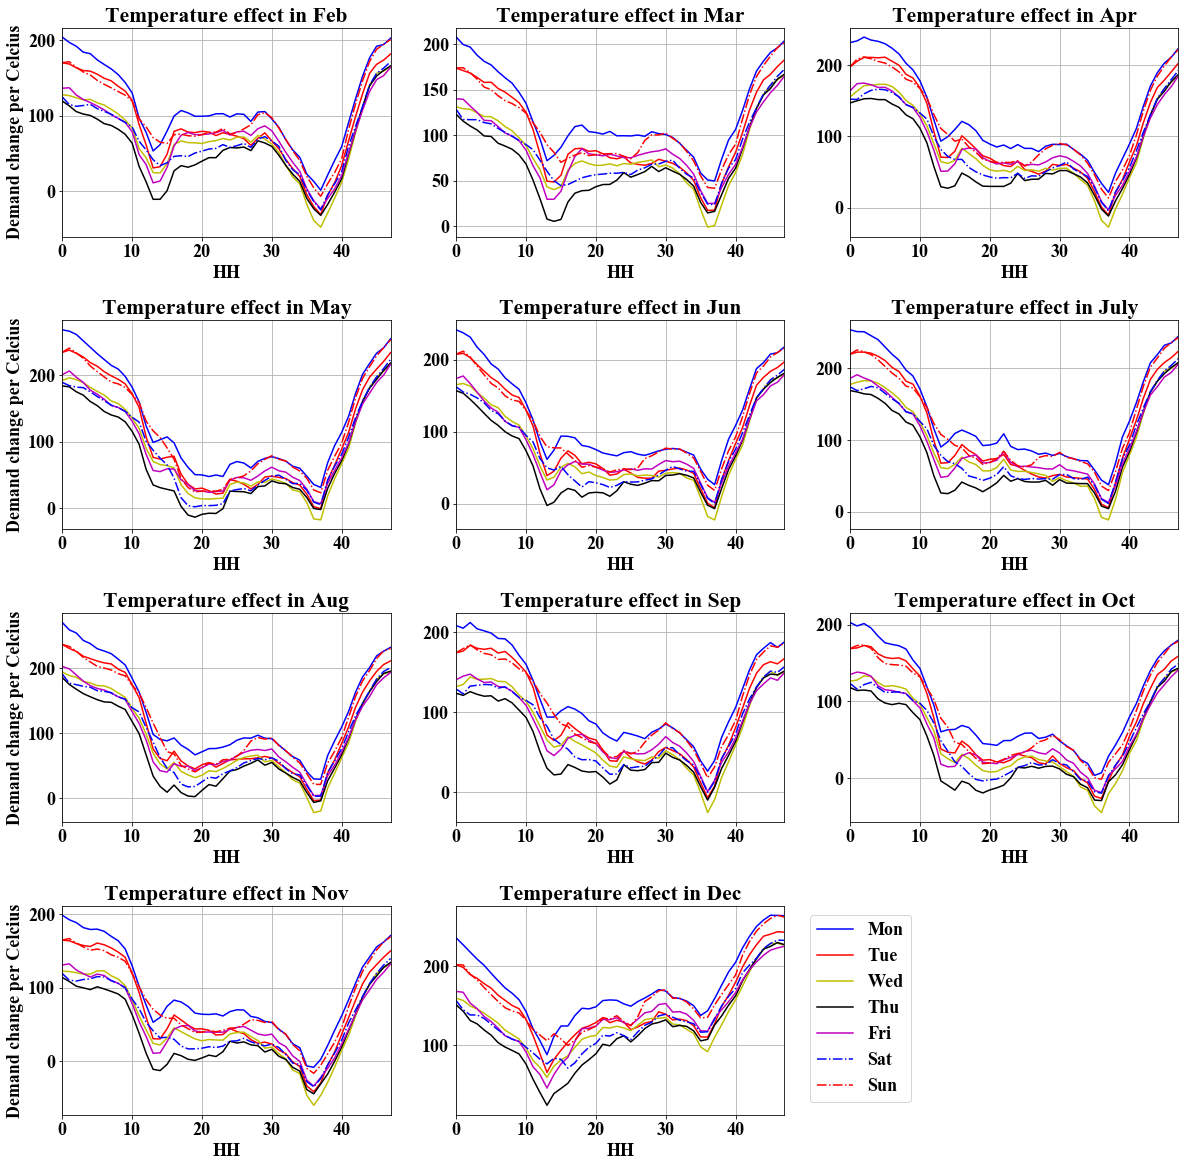

In [29]:
def TempEffect():
    plt.rcParams.update({'font.size': 18})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
    Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for ii in range(11):
        month0=Monthtypes[ii]
        monthTD = 'MD[T.' + month0 + ']:temp' #month and temp dummy
        MaxT='MaxTemp'
        MaxTYestDay='MaxTempYesterday'
        MA2pmT='MA2pmTemp'
        #Tmp='temp'
        
        #'WD[Mon]:temp'
        for d in daytypes:
            p[d] = p['WD[' + d +']:temp'] + p[monthTD] \
            +p[MaxT]+p[MaxTYestDay]+p[MA2pmT]#+p[Tmp]

        plt.rcParams["font.family"] = "Times New Roman"
        chrt+=1
        ax=fig1.add_subplot(4,3,chrt)
        p.loc[:,'Mon':'Sun'].plot(style=styles,grid=True,\
                                  title='Temperature effect in %s' % month0,ax=ax)
        
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        fig1.subplots_adjust(hspace=0.4)
        if ii<=9:
            ax.get_legend().remove()
        if ii%3==0:
            plt.ylabel('Demand change per Celcius')
    
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

TempEffect()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/TemperatureImpact.eps', format='eps', dpi=400)


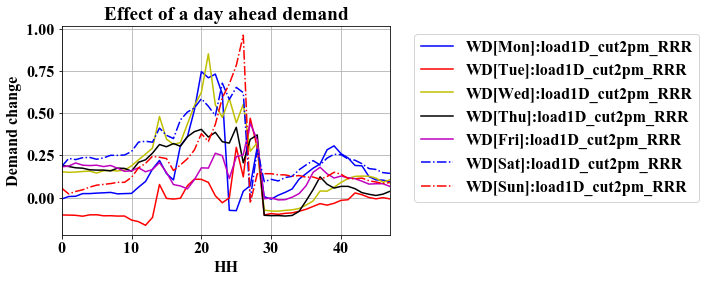

In [30]:
def load1d_cut2pmEffect():
    plt.rcParams.update({'font.size': 16})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
   # Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for d in daytypes:
        p[d] = 'MD[' + d + ']:load1D_cut2pm_RRR' #month and temp dummy
    
    plt.rcParams["font.family"] = "Times New Roman"
    chrt+=1
    ax=fig1.add_subplot(4,3,chrt)
    p.loc[:,'WD[Mon]:load1D_cut2pm_RRR':'WD[Sun]:load1D_cut2pm_RRR'].plot(style=styles,grid=True,\
                              title='Effect of a day ahead demand',ax=ax)
        
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    fig1.subplots_adjust(hspace=0.4)
    if chrt<=9:
        ax.get_legend()
    if chrt%3==1:
        plt.ylabel('Demand change')
    
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

load1d_cut2pmEffect()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChangeDayaheadDemandSc4.eps', format='eps')


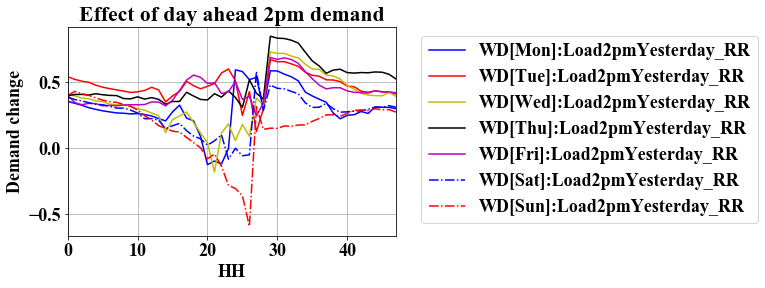

In [31]:
def Load2pmYesterday():
    plt.rcParams.update({'font.size': 18})
    p = Estimated_model_params
    daytypes = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
    
   # Monthtypes = ['Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    fig1=plt.figure(figsize=(20,20))
    chrt=0
    for d in daytypes:
        p[d] = 'MD[' + d + ']:Load2pmYesterday_RR' #month and temp dummy
    
    plt.rcParams["font.family"] = "Times New Roman"
    chrt+=1
    ax=fig1.add_subplot(4,3,chrt)
    p.loc[:,'WD[Mon]:Load2pmYesterday_RR':'WD[Sun]:Load2pmYesterday_RR'].plot(style=styles,grid=True,\
                              title='Effect of day ahead 2pm demand',ax=ax)
        
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    fig1.subplots_adjust(hspace=0.4)
    if chrt<=9:
        ax.get_legend()
    if chrt%3==1:
        plt.ylabel('Demand change')
    
        #plt.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_ylabel('Load change per Celcius increase')
        #ax.legend(bbox_to_anchor=(1.05, 1.0))
        #ax.set_title('Temperature effect in %s' % month0)
        #plt.savefig(r'/Users/kamal/Desktop/Nepal/TUProject/analysis/Image/DemandChangePerC.eps', format='eps')

Load2pmYesterday()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/Image/MLSP_OlsDemandChange2pmYesterdaySc4.eps', format='eps')


In [32]:
Estimated_model_params.columns

Index(['WD[Mon]', 'WD[Tue]', 'WD[Wed]', 'WD[Thu]', 'WD[Fri]', 'WD[Sat]',
       'WD[Sun]', 'MD[T.Feb]', 'MD[T.Mar]', 'MD[T.Apr]', 'MD[T.May]',
       'MD[T.Jun]', 'MD[T.July]', 'MD[T.Aug]', 'MD[T.Sep]', 'MD[T.Oct]',
       'MD[T.Nov]', 'MD[T.Dec]', 'trend', 'WD[Mon]:load1D_cut2pm_RRR',
       'WD[Tue]:load1D_cut2pm_RRR', 'WD[Wed]:load1D_cut2pm_RRR',
       'WD[Thu]:load1D_cut2pm_RRR', 'WD[Fri]:load1D_cut2pm_RRR',
       'WD[Sat]:load1D_cut2pm_RRR', 'WD[Sun]:load1D_cut2pm_RRR',
       'WD[Mon]:Load2pmYesterday_RR', 'WD[Tue]:Load2pmYesterday_RR',
       'WD[Wed]:Load2pmYesterday_RR', 'WD[Thu]:Load2pmYesterday_RR',
       'WD[Fri]:Load2pmYesterday_RR', 'WD[Sat]:Load2pmYesterday_RR',
       'WD[Sun]:Load2pmYesterday_RR', 'MaxTemp', 'MaxTempYesterday',
       'MA2pmTemp', 'WD[Mon]:temp', 'WD[Tue]:temp', 'WD[Wed]:temp',
       'WD[Thu]:temp', 'WD[Fri]:temp', 'WD[Sat]:temp', 'WD[Sun]:temp',
       'MD[T.Feb]:temp', 'MD[T.Mar]:temp', 'MD[T.Apr]:temp', 'MD[T.May]:temp',
       'MD[T.Jun]:temp',

In [33]:
# p = Estimated_model_params
# p['SongkranEff'] = p['Songkran'] + p['Songkran1D']+p['Songkran2D'] 
# p['NewYearEff']=p['Newyear1D']+p['Newyear2D']

# # p['SongkranEfff'] = p['SongkranEff']+p['Songkran1D:Load2pmYesterday_RR']+p['Songkran2D:Load2pmYeserday_RR'] #month and temp dummy
# # p['NewYearEfff']=p['NewYearEff']+p['Newyear1D:Load2pmYesterday_RR']+p['Newyear2D:Load2pmYesterday_RR']

# p['Hol']=p['Asalha']+p['Chakri']+p['Chulalongkorn']+p['Constitution']+p['Coronation']+p['King']\
# +p['Labor']+p['Lent']+p['Makha']+p['Newyear']+p['Ploughing']+p['Queen']+p['Songkran']+p['Visakha']
# ax = p.loc[:,['SongkranEff','NewYearEff','Queen','King','Labor','Chulalongkorn','Visakha']].plot()
# plt.legend(bbox_to_anchor=(1.05, 1.0))
# ax.set_ylabel('load change')

Text(0, 0.5, 'Demand change (MW)')

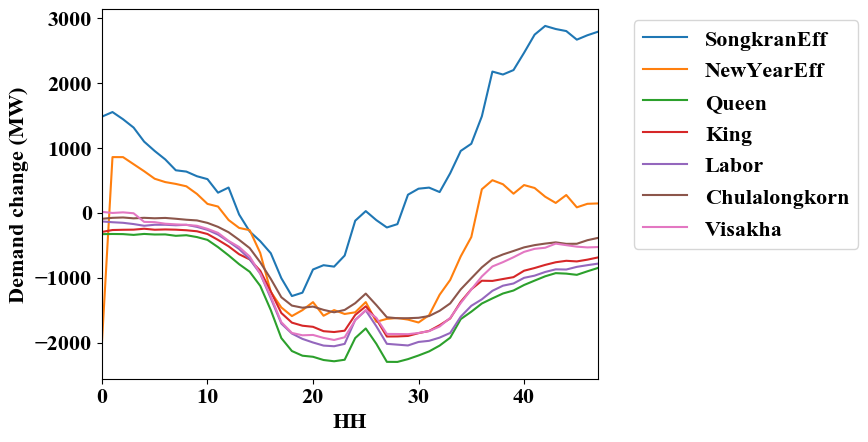

In [99]:
p = Estimated_model_params
p['SongkranEff'] = p['Songkran1D']+p['Songkran2D'] 
p['NewYearEff']=p['Newyear1D']+p['Newyear2D']

# p['SongkranEfff'] = p['SongkranEff']+p['Songkran1D:Load2pmYesterday_RR']+p['Songkran2D:Load2pmYeserday_RR'] #month and temp dummy
# p['NewYearEfff']=p['NewYearEff']+p['Newyear1D:Load2pmYesterday_RR']+p['Newyear2D:Load2pmYesterday_RR']

#p['Hol']=p['Asalha']+p['Chakri']+p['Chulalongkorn']+p['Constitution']+p['Coronation']+p['King']\
#+p['Labor']+p['Lent']+p['Makha']+p['Newyear']+p['Ploughing']+p['Queen']+p['Songkran']+p['Visakha']
ax = p.loc[:,['SongkranEff','NewYearEff','Queen','King','Labor','Chulalongkorn','Visakha']].plot()
plt.legend(bbox_to_anchor=(1.05, 1.0))
ax.set_ylabel('Demand change (MW)')

# Now analysis of Error, MAPE and other stats

In [35]:
df['resid'] = df.loc['2013','load']-df.loc['2013','load_pred']
#df.query('HH==0 & (Holiday == 1 | Holiday2==1)')[['Holiday','Holiday2','WD','MD','HolidayType','Holiday','Holiday2','mape']]
MapeSc4=df.query('Year==2013').loc[:,['Holiday','Holiday2','HolidayType','WD','Weekday','MD','Month','resid','mape']]
MapeSc4.head()

Holiday  Holiday2 HolidayType   WD  Weekday   MD  Month  \
2013-01-01 00:00:00        1         1     Newyear  Tue        1  Jan      1   
2013-01-01 00:30:00        1         1     Newyear  Tue        1  Jan      1   
2013-01-01 01:00:00        1         1     Newyear  Tue        1  Jan      1   
2013-01-01 01:30:00        1         1     Newyear  Tue        1  Jan      1   
2013-01-01 02:00:00        1         1     Newyear  Tue        1  Jan      1   

                          resid       mape  
2013-01-01 00:00:00 -774.670793  22.342191  
2013-01-01 00:30:00 -594.247055  17.646273  
2013-01-01 01:00:00 -564.310523  17.078066  
2013-01-01 01:30:00 -562.140199  17.443415  
2013-01-01 02:00:00 -568.336151  18.041845

In [36]:
MapeSc4.columns

Index(['Holiday', 'Holiday2', 'HolidayType', 'WD', 'Weekday', 'MD', 'Month',
       'resid', 'mape'],
      dtype='object')

In [37]:
MapeSc4withoutHol=df.query('Year==2013 & Holiday2==0').loc[:,['Holiday','Holiday2','HolidayType','WD','Weekday','MD','Month','resid','mape']]
MapeSc4withoutHol.head()

Holiday  Holiday2 HolidayType   WD  Weekday   MD  Month  \
2013-01-02 00:00:00        0         0   Newyear1D  Wed        2  Jan      1   
2013-01-02 00:30:00        0         0   Newyear1D  Wed        2  Jan      1   
2013-01-02 01:00:00        0         0   Newyear1D  Wed        2  Jan      1   
2013-01-02 01:30:00        0         0   Newyear1D  Wed        2  Jan      1   
2013-01-02 02:00:00        0         0   Newyear1D  Wed        2  Jan      1   

                           resid       mape  
2013-01-02 00:00:00 -1471.401425  40.756784  
2013-01-02 00:30:00 -1097.407700  31.614649  
2013-01-02 01:00:00 -1056.550633  31.395903  
2013-01-02 01:30:00 -1060.354353  32.457509  
2013-01-02 02:00:00 -1000.148895  31.454190

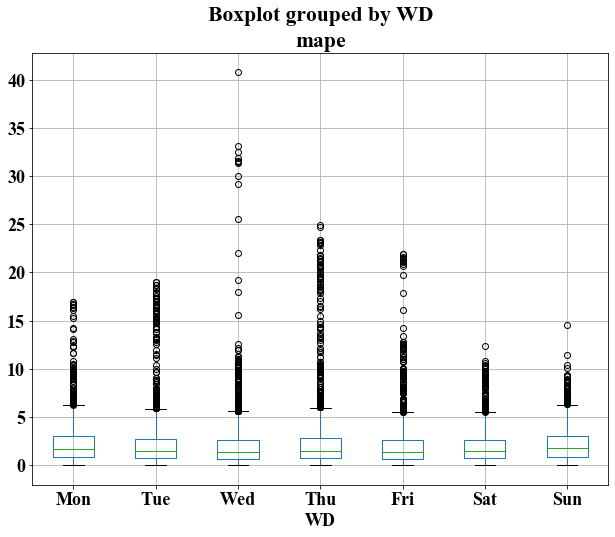

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
MapeSc4withoutHol.boxplot(column=['mape'],by='WD',ax=ax)
#grouped = MapeSc4.groupby(axis=1, level='mape').T
#grouped.boxplot()

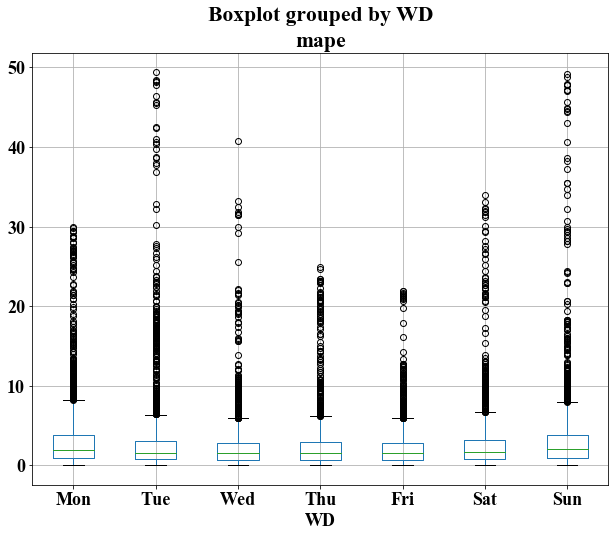

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
MapeSc4.boxplot(column=['mape'],by='WD',ax=ax)


In [40]:
#For daywise
MonMape=MapeSc4.query('Weekday==0 & Holiday2==0').loc[:,['mape']].mean()
TueMape=MapeSc4.query('Weekday==1 & Holiday2==0').loc[:,['mape']].mean()
WedMape=MapeSc4.query('Weekday==2 & Holiday2==0').loc[:,['mape']].mean()
ThuMape=MapeSc4.query('Weekday==3 & Holiday2==0').loc[:,['mape']].mean()
FriMape=MapeSc4.query('Weekday==4 & Holiday2==0').loc[:,['mape']].mean()
SatMape=MapeSc4.query('Weekday==5 & Holiday2==0').loc[:,['mape']].mean()
SunMape=MapeSc4.query('Weekday==6 & Holiday2==0').loc[:,['mape']].mean()

dict={'Mon':MonMape,'Tue':TueMape,'Wed':WedMape,'Thu':ThuMape,'Fri':FriMape,'Sat':SatMape,'Sun':SunMape}
MAPEs = pd.DataFrame(dict)
MAPEs


Mon       Tue       Wed       Thu       Fri       Sat       Sun
mape  2.250127  2.179255  2.100644  2.392187  2.008118  1.924683  2.128387

In [41]:
#For daywise
JanMape=MapeSc4.query('Month==1 & Holiday2==0').loc[:,['mape']].mean()
FebMape=MapeSc4.query('Month==2 & Holiday2==0').loc[:,['mape']].mean()
MarMape=MapeSc4.query('Month==3 & Holiday2==0').loc[:,['mape']].mean()
AprMape=MapeSc4.query('Month==4 & Holiday2==0').loc[:,['mape']].mean()
MayMape=MapeSc4.query('Month==5 & Holiday2==0').loc[:,['mape']].mean()
JunMape=MapeSc4.query('Month==6 & Holiday2==0').loc[:,['mape']].mean()
JulMape=MapeSc4.query('Month==7 & Holiday2==0').loc[:,['mape']].mean()
AugMape=MapeSc4.query('Month==8 & Holiday2==0').loc[:,['mape']].mean()
SepMape=MapeSc4.query('Month==9 & Holiday2==0').loc[:,['mape']].mean()
OctMape=MapeSc4.query('Month==10 & Holiday2==0').loc[:,['mape']].mean()
NovMape=MapeSc4.query('Month==11 & Holiday2==0').loc[:,['mape']].mean()
DecMape=MapeSc4.query('Month==12 & Holiday2==0').loc[:,['mape']].mean()

dict={'Jan':JanMape,'Feb':FebMape,'Mar':MarMape,'Apr':AprMape,'May':MayMape,\
      'Jun':JunMape,'Jul':JulMape,'Aug':AugMape,'Sep':SepMape,'Oct':OctMape,\
      'Nov':NovMape,'Dec':DecMape}
MAPEs = pd.DataFrame(dict)
MAPEs


Jan       Feb       Mar       Apr       May       Jun       Jul  \
mape  2.550481  2.068644  1.461234  2.547296  2.028184  1.530812  2.067354   

           Aug       Sep      Oct       Nov       Dec  
mape  1.490442  1.459424  2.50808  2.707089  4.039427

In [42]:
#For Holiday
MapeSc4withoutHol=df.query('Year==2013 & Holiday2==1').loc[:,['mape']].mean()
MapeSc4withoutHol

mape    7.752056
dtype: float64

In Scenario4, overall mape for holiday is 7.75

In [43]:
df.columns

Index(['load', 'temp', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Weekday',
       'HH', 'old_temp', 'Holiday', 'HolidayType', 'HolidayLong', 'WD', 'MD',
       'Flood', 'WorkingHour', 'load_art', 'trend', 'DayAfterHoliday',
       'DayAfterLongHoliday', 'DayAfterSongkran', 'DayAfterNewyear',
       'MA2pmTemp', 'MaxTemp', 'MaxTempYesterday', 'Load2pmYesterday',
       'Holiday2', 'load1d', 'load2d', 'load3d', 'load4d', 'load5d', 'load6d',
       'load7d', 'load14d', 'load21d', 'load28d', 'load1d_cut2pm',
       'load2d_cut2pm', 'HolidayLongOld', 'DayAfterLongHolidayOld', 'Religion',
       'DayAfterLabor', 'DayAfterReligion', 'load1D_cut2pm_RR',
       'load1D_cut2pm_RR_offset', 'Load2pmYesterday_RR', 'Songkran1D',
       'Songkran2D', 'Newyear1D', 'Newyear2D', 'load1D_cut2pm_RRR', 'Asalha',
       'Chakri', 'Chulalongkorn', 'Constitution', 'Coronation', 'King',
       'Labor', 'Lent', 'Makha', 'Newyear', 'Ploughing', 'Queen', 'Songkran',
       'Visakha', 'load1D_cut2pm_RRR_offset', 

# GLSAR

In [44]:
''' For example, if pred_intervals=2, then we use two prediction intervals. 
We split the 2013 loads into two halfs. 
For the first half, we use data from 2009-3-8 to 2012 as training to predict in 2013-1 to 2013-6. 
For the second half, we use 2009-9-8 to 2013-6 as training to predict in 2013-7 to 2013-12. 
(recall, the prediction is still one-day ahead prediction since we use today load to predict tomorrow load).
''' 
def run_ARMAX(df, model_str, pred_intervals=0, OLS=False, rho=1, printhh=False, train_start='2009-3-8', train_end='2012', test_start='2013', test_end='2013'):
    T = 48
    train = df[train_start:train_end]
    test = df[test_start:test_end]
    train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
    print('Sizes: train=%d, test=%d' % (train_size, test_size))

    if (pred_intervals <= 0):
        pred_intervals = test_size
    # the prediction length for each prediction interval
    pred_len = int(np.ceil(test_size/pred_intervals))
    
    df['load_pred'] = 0

    for hh in range(T):
        print('')
        print('HH=%d, t=' % hh, end = '')
        yhat_all = []
        
        y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
        y = np.asarray(y0)
        X = np.asarray(X0)

        for t in range(pred_intervals):
            print('%d,' % t, end = '')
            hh_train_start = t*pred_len
            hh_train_end = hh_train_start + train_size
            hh_test_start = hh_train_end
            if (t < (pred_intervals - 1)):
                hh_test_end = hh_test_start + pred_len
            else:
                hh_test_end = hh_test_start + (test_size - (t*pred_len))     
                
#             ytrain = y[hh_train_start:hh_train_end]
#             Xtrain = X[hh_train_start:hh_train_end]
            ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
            Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
            ytest = y[hh_test_start:hh_test_end]
            Xtest = X[hh_test_start:hh_test_end]
                
            if (OLS):
                # OLS 
                model = sm.OLS(ytrain, Xtrain)
                model_fit = model.fit(disp=0)
            else:
                ## GLSAR with the number of lags in the noise process is rho
                model = sm.GLSAR(ytrain, Xtrain, rho)
                model_fit = model.iterative_fit(6)

            output = model_fit.predict(Xtest)
            yhat = output
            yhat_all = np.concatenate((yhat_all,yhat))
            
        if (printhh):
            print('hh=%d' % hh)
            print((model_fit.summary()))                
        
        df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = yhat_all
        
    df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
    df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
    mape = df.loc[test_end,'mape'].mean()
    print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
    df.loc[test_end,'mape'].plot()
    plt.grid()
    plt.figure()
    df.loc[test_end,'resid'].plot()
    plt.grid()
    
    plotgroups(df.loc[test_end,['load_pred','load']].resample('M'))
    return mape

In [45]:
model_str_ARMAX = 'load ~ trend + load1d_cut2pm + WD:load1d_cut2pm \
+ load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ temp + WD:temp + MD:temp + WD:np.square(temp)\
+ WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

#Based on revise info structure
model_str_ARMAX_nonholiday = 'load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1\
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR'

df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'
df = df[train_start:test_end]
## only weekdays
df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 4)&(df.Holiday2==0),:] 
df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

Sizes: train=911, test=239

HH=0, t=0,

/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1147: RuntimeWarning: invalid value encountered in true_divide
  diff = np.max(np.abs(last - results.params) / np.abs(last))


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,
HH=1, t=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,5

/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1147: RuntimeWarning: divide by zero encountered in true_divide
  diff = np.max(np.abs(last - results.params) / np.abs(last))


7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,
HH=15, t=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,

HH=32, t=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,
HH=33, t=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,4

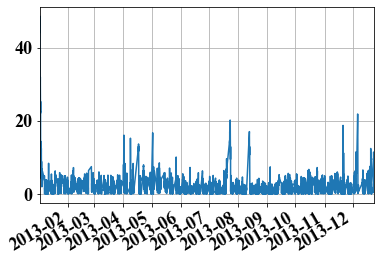

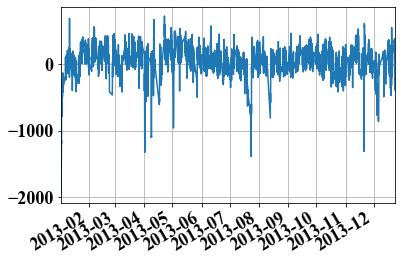

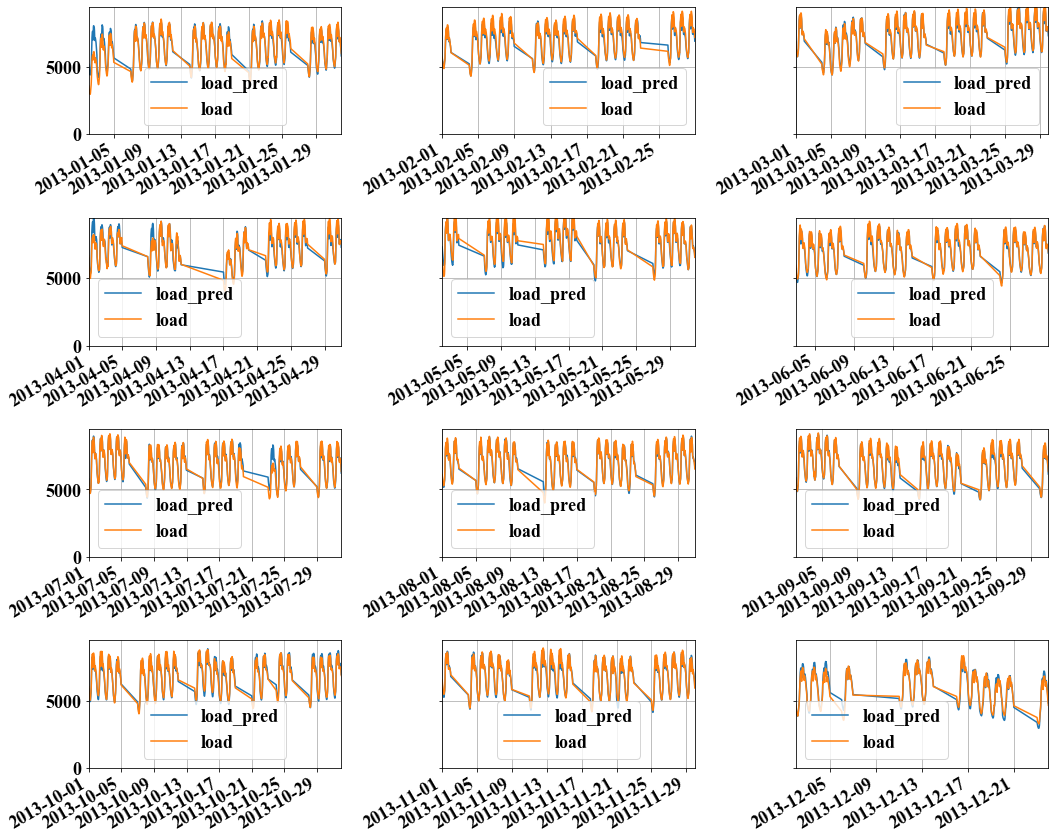

In [46]:
start = time.time()
mape_DNN = run_ARMAX(df=df, model_str=model_str_ARMAX_nonholiday, pred_intervals=0, OLS= False, rho=7,
                   train_start=train_start,train_end=train_end,test_start=test_start,test_end=test_end)
end = time.time()
print('runtime = %0.4f s' % (end - start))

In [47]:
T = 48
df = data.copy()
train_start = '2009-3-8'
train_end = '2012'
test_start = '2013'
test_end = '2013'

df = df[train_start:test_end]

## Scenario 1: Weekdays and non-holiday data
#df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 4)&(df.Holiday2==0),:] 

## Scenario 2: Weekend and non-holiday data
#df = df.loc[(df.Weekday >= 5) & (df.Weekday <= 6)&(df.Holiday2==0),:] 
## include temp^2 --> mape 1.97 (OLS), (GLSAR, rho=1)
model_str = 'load ~ trend + load1d_cut2pm + WD:load1d_cut2pm \
+ load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ temp + WD:temp + MD:temp + WD:np.square(temp)\
+ WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 

## Scenario 3: Holiday only data
# df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 4)&(df.Holiday2==0),:] 

## Scenario 4: Aggregate model
# df = df.loc[(df.Weekday >= 0) & (df.Weekday <= 4)&(df.Holiday2==0),:] 
# mdl_str='load ~ trend + load1d + load2d + load3d + load7d + WD:temp \
# + MD:temp + WD + MD + Holiday + HolidayLong + Flood + Songkran + Newyear'
# model_str = 'load ~ trend + load1d_cut2pm + WD:load1d_cut2pm \
# + load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
# + temp + WD:temp + MD:temp + Holiday + HolidayLong + Flood + Songkran + Newyear\
# + WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 



## remove unused categories to reduce the number of dummy variables 
#df.loc[:,'WD'].cat.remove_unused_categories(inplace=True)

#check 
df.query('HH==0')['WD'].head(8)

2009-03-08    Sun
2009-03-09    Mon
2009-03-10    Tue
2009-03-11    Wed
2009-03-12    Thu
2009-03-13    Fri
2009-03-14    Sat
2009-03-15    Sun
Freq: 1440T, Name: WD, dtype: category
Categories (7, object): [Mon < Tue < Wed < Thu < Fri < Sat < Sun]

Sizes: train=1395, test=365
hh=0 hh=1 hh=2 hh=3 hh=4 hh=5 hh=6 hh=7 hh=8 hh=9 hh=10 hh=11 hh=12 hh=13 hh=14 hh=15 hh=16 hh=17 hh=18 hh=19 hh=20 hh=21 hh=22 hh=23 hh=24 hh=25 hh=26 hh=27 hh=28 hh=29 hh=30 hh=31 hh=32 hh=33 hh=34 hh=35 hh=36 hh=37 hh=38 hh=39 hh=40 hh=41 hh=42 hh=43 hh=44 hh=45 hh=46 hh=47 MAPE over all halfhours in 2013 = 2.81


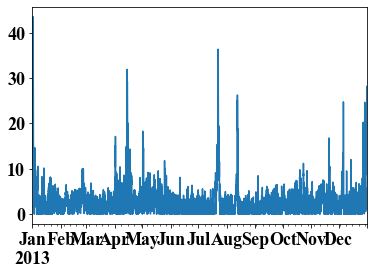

In [48]:
model_str='load ~ trend + WD:load1D_cut2pm_RRR \
+ WD:Load2pmYesterday_RR + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ WD:temp + MD:temp \
+ WD + MD - 1 \
+ Songkran1D + Songkran2D + Newyear1D + Newyear2D \
+ Songkran1D:Load2pmYesterday_RR + Songkran2D:Load2pmYesterday_RR \
+ Newyear1D:Load2pmYesterday_RR + Newyear2D:Load2pmYesterday_RR \
+ Asalha + Chakri + Chulalongkorn + Constitution + Coronation + King + Labor \
+ Lent + Makha + Newyear + Ploughing + Queen + Songkran + Visakha'


from numpy import array
train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

df['load_pred'] = 0
df['load_fitted'] = 0


OutsideList=list() # to save the mean params for the length of testing data (Forecasting)
OutsideListRho=list()
AllParam=list()    # to save each the parameters 

#for hh in range(T):
for hh in range(T):
    predictions = list()
    obs = list()
    InsideList=list()
    InsideListRho=list()

    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)

    for t in range(test_size):
        hh_train_start = t
        hh_train_end = t + train_size
        hh_test = hh_train_end
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test]
        Xtest = X[hh_test]

        
        ## GLSAR with the number of lags in the noise process is rho
        model = sm.GLSAR(ytrain, Xtrain, rho=7)
        model_fit = model.iterative_fit(6)
        output = model_fit.predict(Xtest)
        yhat = output[0]

        InsideListRho.append(model.rho)
        InsideList.append(model_fit.params) #Stores for each hh(t) untill forecasting length
#         yhat = np.dot(model_fit.params, Xtest)
#         print('t=%d, predicted=%.0f, expected=%.0f' % (t,yhat, ytest))
        predictions.append(yhat)
        obs.append(ytest)
        AllParam.append(model_fit.params) #to store all the params
    
    print('hh=%d' % hh, end=' ')
    p=array(InsideList) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideList.append(ppp) #now the mean value for each hh is stored

    #For rho
    p=array(InsideListRho) #converting to arrary for mathmatical operation
    pp=p.mean(axis=0)   #Calculate the mean of forecasting lenth for each hh (columns wise)
    ppp=pp.tolist()     #again converting to list for append
    OutsideListRho.append(ppp) #now the mean value for each hh is stored



    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = predictions
    
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))
df.loc[test_end,'mape'].plot()


In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotgroups(groups):
    plt.rcParams.update({'font.size': 14})
    plt.rcParams["font.family"] = "Times New Roman"
    fa, fb = int(np.ceil(groups.ngroups/3)), 3
    fig, axes = plt.subplots(fa,fb,figsize=(15,3*fa), sharey=True, squeeze=False)
    j = 0
    for name, group in groups:
        group.plot(ax=axes[np.floor_divide(j,fb), np.mod(j,fb)], grid=True)
        j = j + 1
    plt.tight_layout()

In [50]:
data = pd.read_pickle(r'/Users/mac/Desktop/TUproject/analysis/MCC_data_pickle_old')
print('No. of rows and columns:', data.shape)

No. of rows and columns: (84816, 67)


In [51]:
data.head()

load       temp  Year  Month  Day  Hour  Minute  \
2009-03-01 00:00:00  5384.65  26.774702  2009      3    1     0       0   
2009-03-01 00:30:00  5187.65  27.535217  2009      3    1     0      30   
2009-03-01 01:00:00  5066.65  28.100000  2009      3    1     1       0   
2009-03-01 01:30:00  4948.55  28.488527  2009      3    1     1      30   
2009-03-01 02:00:00  4817.80  28.720276  2009      3    1     2       0   

                     Weekday  HH   old_temp  ...  Coronation King  Labor Lent  \
2009-03-01 00:00:00        6   0  26.774702  ...           0    0      0    0   
2009-03-01 00:30:00        6   1  27.535217  ...           0    0      0    0   
2009-03-01 01:00:00        6   2  28.100000  ...           0    0      0    0   
2009-03-01 01:30:00        6   3  28.488527  ...           0    0      0    0   
2009-03-01 02:00:00        6   4  28.720276  ...           0    0      0    0   

                    Makha Newyear Ploughing  Queen  Songkran  Visakha  
2009-03-01 00:00:00     0       0         0      0         0        0  
2009-03-01 00:30:00     0       0         0      0         0        0  
2009-03-01 01:00:00     0       0         0      0         0        0  
2009-03-01 01:30:00     0       0         0      0         0        0  
2009-03-01 02:00:00     0       0         0      0         0        0  

[5 rows x 67 columns]

In [52]:
# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# data.loc['2009-3-2':'2009-3-15','load'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


In [53]:
dfThesis=data.copy()

In [54]:
dfThesis=data.rename(columns = {"load": "Demand", "temp":"Temp"}) 
dfThesis.head(50)

Demand       Temp  Year  Month  Day  Hour  Minute  \
2009-03-01 00:00:00  5384.65  26.774702  2009      3    1     0       0   
2009-03-01 00:30:00  5187.65  27.535217  2009      3    1     0      30   
2009-03-01 01:00:00  5066.65  28.100000  2009      3    1     1       0   
2009-03-01 01:30:00  4948.55  28.488527  2009      3    1     1      30   
2009-03-01 02:00:00  4817.80  28.720276  2009      3    1     2       0   
2009-03-01 02:30:00  4736.65  28.814725  2009      3    1     2      30   
2009-03-01 03:00:00  4612.60  28.791350  2009      3    1     3       0   
2009-03-01 03:30:00  4551.40  28.669629  2009      3    1     3      30   
2009-03-01 04:00:00  4468.50  28.469039  2009      3    1     4       0   
2009-03-01 04:30:00  4394.55  28.209059  2009      3    1     4      30   
2009-03-01 05:00:00  4359.10  27.909165  2009      3    1     5       0   
2009-03-01 05:30:00  4310.10  27.588835  2009      3    1     5      30   
2009-03-01 06:00:00  4332.25  27.267545  2009      3    1     6       0   
2009-03-01 06:30:00  4166.85  26.964775  2009      3    1     6      30   
2009-03-01 07:00:00  3988.50  26.700000  2009      3    1     7       0   
2009-03-01 07:30:00  4038.00  26.492699  2009      3    1     7      30   
2009-03-01 08:00:00  4066.70  26.362348  2009      3    1     8       0   
2009-03-01 08:30:00  4209.50  26.328425  2009      3    1     8      30   
2009-03-01 09:00:00  4350.50  26.410408  2009      3    1     9       0   
2009-03-01 09:30:00  4444.75  26.627774  2009      3    1     9      30   
2009-03-01 10:00:00  4529.40  27.000000  2009      3    1    10       0   
2009-03-01 10:30:00  4649.70  27.532461  2009      3    1    10      30   
2009-03-01 11:00:00  4731.40  28.174122  2009      3    1    11       0   
2009-03-01 11:30:00  4771.40  28.859845  2009      3    1    11      30   
2009-03-01 12:00:00  4720.45  29.524490  2009      3    1    12       0   
2009-03-01 12:30:00  4712.60  30.102922  2009      3    1    12      30   
2009-03-01 13:00:00  4725.20  30.530000  2009      3    1    13       0   
2009-03-01 13:30:00  4793.60  30.758197  2009      3    1    13      30   
2009-03-01 14:00:00  4815.00  30.810423  2009      3    1    14       0   
2009-03-01 14:30:00  4795.00  30.727197  2009      3    1    14      30   
2009-03-01 15:00:00  4755.50  30.549038  2009      3    1    15       0   
2009-03-01 15:30:00  4701.05  30.316466  2009      3    1    15      30   
2009-03-01 16:00:00  4658.80  30.070000  2009      3    1    16       0   
2009-03-01 16:30:00  4596.45  29.841834  2009      3    1    16      30   
2009-03-01 17:00:00  4581.00  29.630853  2009      3    1    17       0   
2009-03-01 17:30:00  4617.00  29.427619  2009      3    1    17      30   
2009-03-01 18:00:00  4672.75  29.222692  2009      3    1    18       0   
2009-03-01 18:30:00  4960.40  29.006632  2009      3    1    18      30   
2009-03-01 19:00:00  5218.70  28.770000  2009      3    1    19       0   
2009-03-01 19:30:00  5286.55  28.506969  2009      3    1    19      30   
2009-03-01 20:00:00  5312.50  28.226165  2009      3    1    20       0   
2009-03-01 20:30:00  5358.75  27.939826  2009      3    1    20      30   
2009-03-01 21:00:00  5298.90  27.660194  2009      3    1    21       0   
2009-03-01 21:30:00  5274.10  27.399505  2009      3    1    21      30   
2009-03-01 22:00:00  5168.30  27.170000  2009      3    1    22       0   
2009-03-01 22:30:00  5000.90  26.979134  2009      3    1    22      30   
2009-03-01 23:00:00  4868.50  26.815229  2009      3    1    23       0   
2009-03-01 23:30:00  4649.70  26.661825  2009      3    1    23      30   
2009-03-02 00:00:00  4487.65  26.502459  2009      3    2     0       0   
2009-03-02 00:30:00  4281.65  26.320671  2009      3    2     0      30   

                     Weekday  HH   old_temp  ...  Coronation King  Labor Lent  \
2009-03-01 00:00:00        6   0  26.774702  ...           0    0      0    0   
2009-03-01 00:30:00        6   1  

In [55]:
dfThesis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84816 entries, 2009-03-01 00:00:00 to 2013-12-31 23:30:00
Freq: 30T
Data columns (total 67 columns):
Demand                     84816 non-null float64
Temp                       84816 non-null float64
Year                       84816 non-null int64
Month                      84816 non-null int64
Day                        84816 non-null int64
Hour                       84816 non-null int64
Minute                     84816 non-null int64
Weekday                    84816 non-null int64
HH                         84816 non-null int64
old_temp                   84816 non-null float64
Holiday                    84816 non-null int64
HolidayType                84816 non-null category
HolidayLong                84816 non-null int64
WD                         84816 non-null category
MD                         84816 non-null category
Flood                      84816 non-null category
WorkingHour                84816 non-null category
load_art 

In [56]:
dfThesis.describe()

Demand          Temp          Year         Month           Day  \
count  84816.000000  84816.000000  84816.000000  84816.000000  84816.000000   
mean    6210.631009     28.861216   2011.067346      6.692134     15.742501   
std     1308.464428      3.041413      1.388575      3.376637      8.806331   
min     1649.300000     16.366439   2009.000000      1.000000      1.000000   
25%     5191.592814     26.707405   2010.000000      4.000000      8.000000   
50%     6157.853544     28.623515   2011.000000      7.000000     16.000000   
75%     7242.114272     31.000783   2012.000000     10.000000     23.000000   
max    10013.350000     38.659490   2013.000000     12.000000     31.000000   

               Hour        Minute       Weekday            HH      old_temp  \
count  84816.000000  84816.000000  84816.000000  84816.000000  84816.000000   
mean      11.500000     15.000000      2.998868     23.500000     28.828681   
std        6.922227     15.000088      2.001426     13.853481      3.118494   
min        0.000000      0.000000      0.000000      0.000000     11.663584   
25%        5.750000      0.000000      1.000000     11.750000     26.690316   
50%       11.500000     15.000000      3.000000     23.500000     28.607813   
75%       17.250000     30.000000      5.000000     35.250000     30.994951   
max       23.000000     30.000000      6.000000     47.000000     42.872006   

       ...    Coronation          King         Labor          Lent  \
count  ...  84816.000000  84816.000000  84816.000000  84816.000000   
mean   ...      0.005093      0.006225      0.005659      0.001132   
std    ...      0.071186      0.078655      0.075016      0.033624   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

              Makha       Newyear     Ploughing         Queen      Songkran  \
count  84816.000000  84816.000000  84816.000000  84816.000000  84816.000000   
mean       0.005659      0.006225      0.002830      0.006225      0.010187   
std        0.075016      0.078655      0.053119      0.078655      0.100415   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Visakha  
count  84816.000000  
mean       0.003962  
std        0.062816  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 62 columns]

In [57]:
# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# data.loc['2009-3-2':'2009-3-15','load'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


# Some works for figure plotting

for daytypes:

<Figure size 864x432 with 0 Axes>

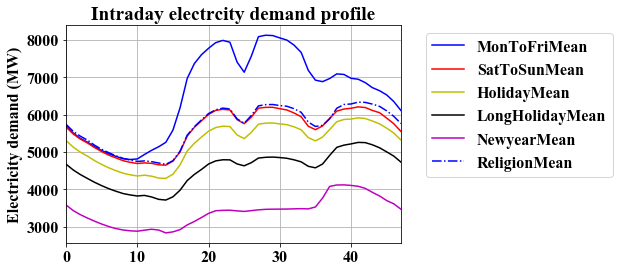

In [58]:
#Im plotting figures for detail characteristics of 'demand'

MonToFri=dfThesis[(dfThesis.Weekday>=0)&(dfThesis.Weekday<=4)&(df.Holiday2==0)&(df.Songkran==0)&(df.Newyear==0)] 
SatToSun=dfThesis[(dfThesis.Weekday>=5)] 
DataHoliday=dfThesis[(dfThesis.Holiday==1)] # Not considering Holiday2 because Holiday2 consist some volatile weekdays too
LongHoliday=dfThesis[(dfThesis.HolidayLong==1)] # Only the long holidays
DataNewyear=dfThesis[(dfThesis.Newyear==1)] 
DataReligion=dfThesis[(dfThesis.Religion==1)] 
DataDayAfterHoliday=dfThesis[(dfThesis.DayAfterHoliday==1)] 
DataDayAfterReligion=dfThesis[(dfThesis.DayAfterReligion==1)] 
DataDayAfterNewyear=dfThesis[(dfThesis.DayAfterNewyear==1)] 
DataDayAfterLongHoliday=dfThesis[(dfThesis.DayAfterLongHoliday==1)] 
DataDayAfterSongkran=dfThesis[(dfThesis.DayAfterSongkran==1)] 

#Groupby function is the best for this purpose..
MonToFriHH=MonToFri.groupby('HH')
SatToSunHH=SatToSun.groupby('HH')
DataHolidayHH=DataHoliday.groupby('HH')
LongHolidayHH=LongHoliday.groupby('HH')
DataNewyearHH=DataNewyear.groupby('HH')
DataReligionHH=DataReligion.groupby('HH')
DataDayAfterHolidayHH=DataDayAfterHoliday.groupby('HH')
DataDayAfterReligionHH=DataDayAfterReligion.groupby('HH')
DataDayAfterNewyearHH=DataDayAfterNewyear.groupby('HH')
DataDayAfterLongHolidayHH=DataDayAfterLongHoliday.groupby('HH')
DataDayAfterSongkranHH=DataDayAfterSongkran.groupby('HH')

#Hourwise mean
MonToFriMean=MonToFriHH.mean()
SatToSunMean=SatToSunHH.mean()
DataHolidayMean=DataHolidayHH.mean()
LongHolidayMean=LongHolidayHH.mean()
DataNewyearMean=DataNewyearHH.mean()
DataReligionMean=DataReligionHH.mean()
DataDayAfterHolidayMean=DataDayAfterHolidayHH.mean()
DataDayAfterReligionMean=DataDayAfterReligionHH.mean()
DataDayAfterNewyearMean=DataDayAfterNewyearHH.mean()
DataDayAfterLongHolidayMean=DataDayAfterLongHolidayHH.mean()
DataDayAfterSongkranMean=DataDayAfterSongkranHH.mean()

#Creating new dataframe for hh=0 to 47
HourwiseMeanX=MonToFriMean.copy()
HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['SatToSunMean']=SatToSunMean.loc[:,'Demand']
HourwiseMeanX['HolidayMean']=DataHolidayMean.loc[:,'Demand']
HourwiseMeanX['LongHolidayMean']=LongHolidayMean.loc[:,'Demand']
HourwiseMeanX['NewyearMean']=DataNewyearMean.loc[:,'Demand']
HourwiseMeanX['ReligionMean']=DataReligionMean.loc[:,'Demand']
HourwiseMeanX['DayAfterHolidayMean']=DataDayAfterHolidayMean.loc[:,'Demand']
HourwiseMeanX['DayAfterReligionMean']=DataDayAfterReligionMean.loc[:,'Demand']
HourwiseMeanX['DayAfterNewyearMean']=DataDayAfterNewyearMean.loc[:,'Demand']
HourwiseMeanX['DayAfterLongHolidayMean']=DataDayAfterLongHolidayMean.loc[:,'Demand']
HourwiseMeanX['DayAfterSongkranMean']=DataDayAfterSongkranMean.loc[:,'Demand']



# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# HourwiseMeanX.loc[:,'MonToFriMean'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,'MonToFriMean':'ReligionMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand (MW)')
ax.xaxis.label.set_visible(False)
#plt.xlabel('Half-hours')
#plt.axis('off')
ax.legend(bbox_to_anchor=(1.05, 1.0))
# plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/MonToFriMean_ReligionMeanEPS.eps',dpi=400, format='eps')
# plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/MonToFriMean_ReligionMeanPNG.png', dpi=400, format='png')




In [59]:
# plt.rcParams.update({'font.size': 14})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
# ax = HourwiseMeanX.loc[:,'MonToFriMean':'ReligionMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
# ax.set_ylabel('Electricity demand (MW)')
# plt.xlabel('Half-hours')
# ax.legend(bbox_to_anchor=(1.05, 1.0))
# plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/MonToFriMean_ReligionMean.eps',dpi=400, format='eps')



For day after holidays and other graphs

<Figure size 864x432 with 0 Axes>

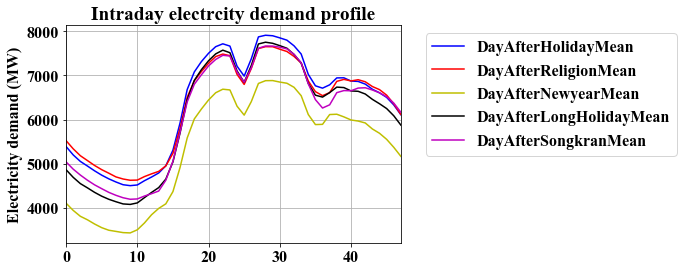

In [60]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,'DayAfterHolidayMean':'DayAfterSongkranMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand (MW)')
ax.legend(bbox_to_anchor=(1.05, 1.0))
ax.xaxis.label.set_visible(False)
#plt.xlabel('Half-hours')

Text(0.5, 0, 'Half-hours')

<Figure size 864x432 with 0 Axes>

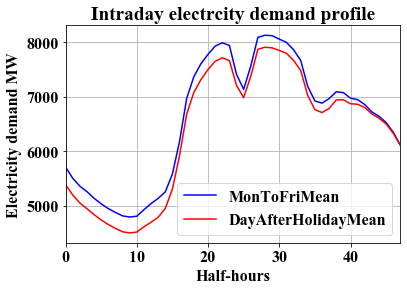

In [61]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,['MonToFriMean','DayAfterHolidayMean']].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand MW')
#ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('Half-hours')

In [62]:
#dfThesis.columns

In [63]:
#Jan=dfThesis[(dfThesis.Month==1)]
#Jan

Now for Months and days,

<Figure size 864x432 with 0 Axes>

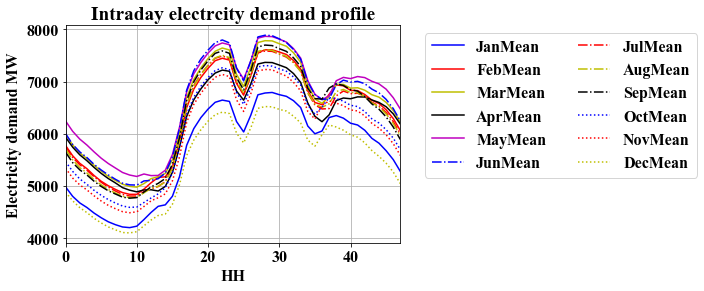

In [72]:
#Now for Months and days,
Jan=dfThesis[(dfThesis.Month==1)]
Feb=dfThesis[(dfThesis.Month==2)]
Mar=dfThesis[(dfThesis.Month==3)]
Apr=dfThesis[(dfThesis.Month==4)]
May=dfThesis[(dfThesis.Month==5)]
Jun=dfThesis[(dfThesis.Month==6)]
Jul=dfThesis[(dfThesis.Month==7)]
Aug=dfThesis[(dfThesis.Month==8)]
Sep=dfThesis[(dfThesis.Month==9)]
Oct=dfThesis[(dfThesis.Month==10)]
Nov=dfThesis[(dfThesis.Month==11)]
Dec=dfThesis[(dfThesis.Month==12)]

#Groupby function is the best for this purpose..
JanHH=Jan.groupby('HH')
FebHH=Feb.groupby('HH')
MarHH=Mar.groupby('HH')
AprHH=Apr.groupby('HH')
MayHH=May.groupby('HH')
JunHH=Jun.groupby('HH')
JulHH=Jul.groupby('HH')
AugHH=Aug.groupby('HH')
SepHH=Sep.groupby('HH')
OctHH=Oct.groupby('HH')
NovHH=Nov.groupby('HH')
DecHH=Dec.groupby('HH')

#Hourwise mean
JanMean=JanHH.mean()
FebMean=FebHH.mean()
MarMean=MarHH.mean()
AprMean=AprHH.mean()
MayMean=MayHH.mean()
JunMean=JunHH.mean()
JulMean=JulHH.mean()
AugMean=AugHH.mean()
SepMean=SepHH.mean()
OctMean=OctHH.mean()
NovMean=NovHH.mean()
DecMean=DecHH.mean()


#Creating new dataframe for hh=0 to 47
HourwiseMeanX=JanMean.copy()
HourwiseMeanX['JanMean']=JanMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['FebMean']=FebMean.loc[:,'Demand']
HourwiseMeanX['MarMean']=MarMean.loc[:,'Demand']
HourwiseMeanX['AprMean']=AprMean.loc[:,'Demand']
HourwiseMeanX['MayMean']=MayMean.loc[:,'Demand']
HourwiseMeanX['JunMean']=JunMean.loc[:,'Demand']
HourwiseMeanX['JulMean']=JulMean.loc[:,'Demand']
HourwiseMeanX['AugMean']=AugMean.loc[:,'Demand']
HourwiseMeanX['SepMean']=SepMean.loc[:,'Demand']
HourwiseMeanX['OctMean']=OctMean.loc[:,'Demand']
HourwiseMeanX['NovMean']=NovMean.loc[:,'Demand']
HourwiseMeanX['DecMean']=DecMean.loc[:,'Demand']

# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# HourwiseMeanX.loc[:,'MonToFriMean'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,'JanMean':'DecMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand MW')
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=2)
#plt.xlabel('Half-hours')


In [65]:
#dfThesis.columns
# dfThesis_Daily=dfThesis.resample('D').mean()# just try
# dfThesis_Daily.head(1)

NameError: name 'color' is not defined

<Figure size 1440x1152 with 0 Axes>

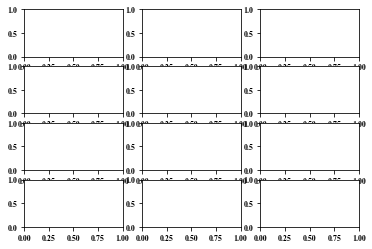

In [73]:
NewHourWiseMeanX=HourwiseMeanX.filter(['JanMean', 'FebMean', 'MarMean', 'AprMean','MayMean', 'JunMean', 'JulMean', 'AugMean','SepMean', 'OctMean','NovMean', 'DecMean'],axis=1)
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
# styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
# ax = HourwiseMeanX.loc[:,'JanMean':'DecMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
# ax.set_ylabel('Electricity demand MW')
# ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=2)
# plt.xlabel('Half-hours')

fig2, axes = plt.subplots(nrows=4, ncols=3)
for i, ax in enumerate(axes.flatten()):
    NewHourWiseMeanX[NewHourWiseMeanX.columns[i]].plot(color=color, ax=ax)
    fig2.subplots_adjust(hspace=0.8)
    #fig2.subplots_adjust(vspace=0.5)
    ax.set_title(NewHourWiseMeanX.columns[i])
    
#     if i%3==0:
#         plt.ylabel('Load change per Celcius')
    if i%3>=1:
        ax.set_yticks([])
#     if i<=9:
#         ax.get_xlabel.remove()
#         #plt.xlabel([])
        

    #         if ii<=9:
#             ax.get_legend().remove()
#         if ii%3==0:
#             plt.ylabel('Load change per Celcius')

In [74]:
NewHourWiseMeanX=HourwiseMeanX.filter(['JanMean', 'FebMean', 'MarMean', 'AprMean','MayMean', 'JunMean', 'JulMean', 'AugMean','SepMean', 'OctMean','NovMean', 'DecMean'],axis=1)
NewHourWiseMeanX.head(1)

JanMean      FebMean     MarMean      AprMean      MayMean  \
HH                                                                   
0   4985.448634  5777.775402  5987.87846  5935.353514  6246.520427   

        JunMean      JulMean      AugMean      SepMean      OctMean  \
HH                                                                    
0   6005.711067  5755.805776  5708.939606  5649.333765  5469.573978   

       NovMean      DecMean  
HH                           
0   5343.81543  4887.356266

In [75]:
#del HourwiseMeanX
#Again for plotting for all the months for different years,
Jan=dfThesis[(dfThesis.Month==1)]
Feb=dfThesis[(dfThesis.Month==2)]
Mar=dfThesis[(dfThesis.Month==3)]
Apr=dfThesis[(dfThesis.Month==4)]
May=dfThesis[(dfThesis.Month==5)]
Jun=dfThesis[(dfThesis.Month==6)]
Jul=dfThesis[(dfThesis.Month==7)]
Aug=dfThesis[(dfThesis.Month==8)]
Sep=dfThesis[(dfThesis.Month==9)]
Oct=dfThesis[(dfThesis.Month==10)]
Nov=dfThesis[(dfThesis.Month==11)]
Dec=dfThesis[(dfThesis.Month==12)]

#Groupby function is the best for this purpose..
JanYear=Jan.groupby('Year')
FebYear=Feb.groupby('Year')
MarYear=Mar.groupby('Year')
AprYear=Apr.groupby('Year')
MayYear=May.groupby('Year')
JunYear=Jun.groupby('Year')
JulYear=Jul.groupby('Year')
AugYear=Aug.groupby('Year')
SepYear=Sep.groupby('Year')
OctYear=Oct.groupby('Year')
NovYear=Nov.groupby('Year')
DecYear=Dec.groupby('Year')

#Hourwise mean
JanMean=JanYear.mean()
FebMean=FebYear.mean()
MarMean=MarYear.mean()
AprMean=AprYear.mean()
MayMean=MayYear.mean()
JunMean=JunYear.mean()
JulMean=JulYear.mean()
AugMean=AugYear.mean()
SepMean=SepYear.mean()
OctMean=OctYear.mean()
NovMean=NovYear.mean()
DecMean=DecYear.mean()



In [76]:

#Creating new dataframe for hh=0 to 47
HourwiseMeanX=JanMean.copy()
HourwiseMeanX['JanMean']=JanMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['FebMean']=FebMean.loc[:,'Demand']
HourwiseMeanX['MarMean']=MarMean.loc[:,'Demand']
HourwiseMeanX['AprMean']=AprMean.loc[:,'Demand']
HourwiseMeanX['MayMean']=MayMean.loc[:,'Demand']
HourwiseMeanX['JunMean']=JunMean.loc[:,'Demand']
HourwiseMeanX['JulMean']=JulMean.loc[:,'Demand']
HourwiseMeanX['AugMean']=AugMean.loc[:,'Demand']
HourwiseMeanX['SepMean']=SepMean.loc[:,'Demand']
HourwiseMeanX['OctMean']=OctMean.loc[:,'Demand']
HourwiseMeanX['NovMean']=NovMean.loc[:,'Demand']
HourwiseMeanX['DecMean']=DecMean.loc[:,'Demand']
HourwiseMeanX

Demand       Temp  Month   Day  Hour  Minute   Weekday    HH  \
Year                                                                      
2010  5490.535705  27.461712    1.0  16.0  11.5    15.0  3.193548  23.5   
2011  5479.991797  26.486742    1.0  16.0  11.5    15.0  3.064516  23.5   
2012  5473.595914  28.014471    1.0  16.0  11.5    15.0  2.935484  23.5   
2013  6155.611667  27.640716    1.0  16.0  11.5    15.0  2.903226  23.5   

       old_temp   Holiday  ...      MarMean      AprMean      MayMean  \
Year                       ...                                          
2010  27.461712  0.032258  ...  6478.864433  6321.779087  6565.080461   
2011  26.486742  0.032258  ...  6095.403159  6009.295481  6523.328101   
2012  28.014471  0.032258  ...  6927.748238  6617.484067  6990.106707   
2013  27.640716  0.032258  ...  7111.324798  6713.585972  7361.316697   

          JunMean      JulMean      AugMean      SepMean      OctMean  \
Year                                                                    
2010  6713.462982  6347.282292  6120.324429  6330.475014  5976.533669   
2011  6586.696061  6297.508364  6390.858480  6462.976893  5643.597659   
2012  6695.586690  6618.806339  6425.762612  6394.117783  6504.947256   
2013  6836.563813  6594.724921  6675.708240  6629.905971  6556.682559   

          NovMean      DecMean  
Year                            
2010  5942.305332  5584.256864  
2011  5157.041708  4728.773935  
2012  6584.019097  6257.750181  
2013  6595.675505  5284.132417  

[4 rows x 73 columns]

In [77]:
NewHourWiseMeanX=HourwiseMeanX.filter(['JanMean', 'FebMean', 'MarMean', 'AprMean','MayMean', 'JunMean', 'JulMean', 'AugMean','SepMean', 'OctMean','NovMean', 'DecMean'],axis=1)
#NewHourWiseMeanX
NewHourWiseMeanXrename=NewHourWiseMeanX.rename(columns = {"JanMean":"Jan","FebMean":"Feb",\
                                                    "MarMean":"Mar","AprMean":"Apr",\
                                                    "MayMean":"May","JunMean":"Jun","JulMean":"Jul",\
                                                    "AugMean":"Aug","SepMean":"Sep",\
                                                    "OctMean":"Oct","NovMean":"Nov","DecMean":"Dec"})
NewHourWiseMeanXrename.head(1)

Jan          Feb          Mar          Apr          May  \
Year                                                                    
2010  5490.535705  6156.310934  6478.864433  6321.779087  6565.080461   

              Jun          Jul          Aug          Sep          Oct  \
Year                                                                    
2010  6713.462982  6347.282292  6120.324429  6330.475014  5976.533669   

              Nov          Dec  
Year                            
2010  5942.305332  5584.256864

In [ ]:
# NewYearWiseMeanWithoutIndex=NewHourWiseMeanXrename.reset_index(inplace=True)
# NewYearWiseMeanWithoutIndex
# tmp=['2010','2011','2012','2013']
# NewYrAdd=NewHourWiseMeanXrename.insert(1, 'group', tmp)
# NewYrAdd

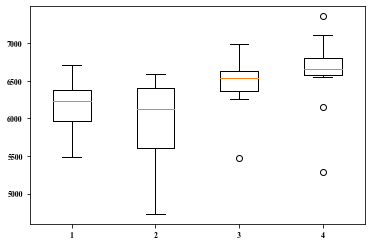

In [78]:
# del HourwiseMeanX
# del NewHourWiseMeanX

#Again for plotting for all the months for different years,
Jan=dfThesis[(dfThesis.Month==1)]
Feb=dfThesis[(dfThesis.Month==2)]
Mar=dfThesis[(dfThesis.Month==3)]
Apr=dfThesis[(dfThesis.Month==4)]
May=dfThesis[(dfThesis.Month==5)]
Jun=dfThesis[(dfThesis.Month==6)]
Jul=dfThesis[(dfThesis.Month==7)]
Aug=dfThesis[(dfThesis.Month==8)]
Sep=dfThesis[(dfThesis.Month==9)]
Oct=dfThesis[(dfThesis.Month==10)]
Nov=dfThesis[(dfThesis.Month==11)]
Dec=dfThesis[(dfThesis.Month==12)]

#Groupby function is the best for this purpose..
JanYear=Jan.groupby('Year')
FebYear=Feb.groupby('Year')
MarYear=Mar.groupby('Year')
AprYear=Apr.groupby('Year')
MayYear=May.groupby('Year')
JunYear=Jun.groupby('Year')
JulYear=Jul.groupby('Year')
AugYear=Aug.groupby('Year')
SepYear=Sep.groupby('Year')
OctYear=Oct.groupby('Year')
NovYear=Nov.groupby('Year')
DecYear=Dec.groupby('Year')

#Hourwise mean
JanMean=JanYear.mean()
FebMean=FebYear.mean()
MarMean=MarYear.mean()
AprMean=AprYear.mean()
MayMean=MayYear.mean()
JunMean=JunYear.mean()
JulMean=JulYear.mean()
AugMean=AugYear.mean()
SepMean=SepYear.mean()
OctMean=OctYear.mean()
NovMean=NovYear.mean()
DecMean=DecYear.mean()

#Creating new dataframe for hh=0 to 47
HourwiseMeanX=JanMean.copy()
HourwiseMeanX['JanMean']=JanMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['FebMean']=FebMean.loc[:,'Demand']
HourwiseMeanX['MarMean']=MarMean.loc[:,'Demand']
HourwiseMeanX['AprMean']=AprMean.loc[:,'Demand']
HourwiseMeanX['MayMean']=MayMean.loc[:,'Demand']
HourwiseMeanX['JunMean']=JunMean.loc[:,'Demand']
HourwiseMeanX['JulMean']=JulMean.loc[:,'Demand']
HourwiseMeanX['AugMean']=AugMean.loc[:,'Demand']
HourwiseMeanX['SepMean']=SepMean.loc[:,'Demand']
HourwiseMeanX['OctMean']=OctMean.loc[:,'Demand']
HourwiseMeanX['NovMean']=NovMean.loc[:,'Demand']
HourwiseMeanX['DecMean']=DecMean.loc[:,'Demand']

# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# HourwiseMeanX.loc[:,'MonToFriMean'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()

NewHourWiseMeanX=HourwiseMeanX.filter(['JanMean', 'FebMean', 'MarMean', 'AprMean','MayMean', 'JunMean', 'JulMean', 'AugMean','SepMean', 'OctMean','NovMean', 'DecMean'],axis=1)

box_plot_data=NewHourWiseMeanX
plt.boxplot(box_plot_data)
plt.show()


# plt.rcParams.update({'font.size': 16})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(16,16))
# styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
# ax = HourwiseMeanX.loc[:,'Years'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
# ax.set_ylabel('Electricity demand MW')
# ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=2)
# plt.xlabel('Half-hours')




In [ ]:
import numpy.random as random
n=1000
dftTest = pd.DataFrame(random.randn(n), pd.date_range('2010-01-01', periods=n), columns=["data"])
dftTest['Dates'] = dftTest.index
dftTest['week_days'] =dftTest.index.weekday
dftTest.head()

([<matplotlib.axis.XTick at 0x1c2d9d4748>,
 <a list of 12 Text xticklabel objects>)

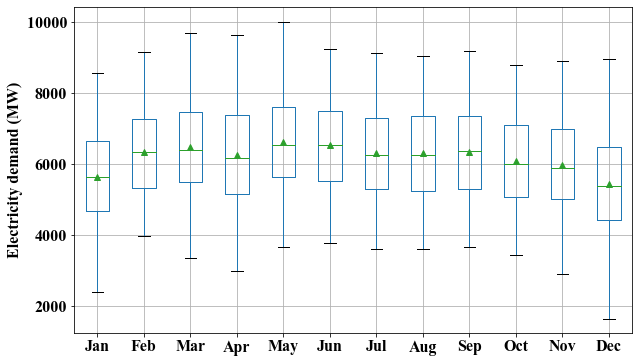

In [79]:
# import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10,6))
# plt.rcParams["axes.grid"] = False
ax =dfThesis.pivot(columns='Month', values='Demand')
ax.boxplot(showmeans=True)
#plt.xlable("Months")
plt.ylabel("Electricity demand (MW)")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]) 


([<matplotlib.axis.XTick at 0x1c2b7aac50>,
 <a list of 12 Text xticklabel objects>)

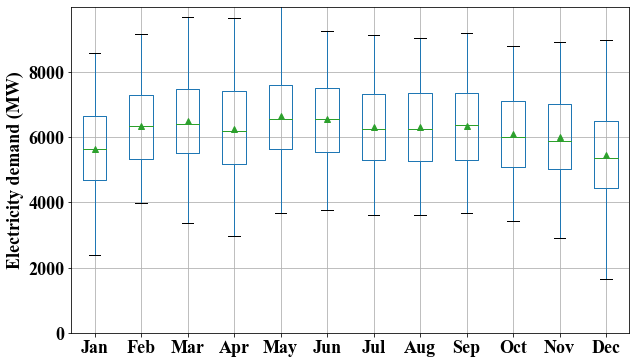

In [80]:
# import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10,6))
# plt.rcParams["axes.grid"] = False
ax =dfThesis.pivot(columns='Month', values='Demand')
ax.boxplot(showmeans=True)

plt.ylim(0,9999)
#plt.xlable("Months")
plt.ylabel("Electricity demand (MW)")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]) 

#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/MonthwiseDemand.eps', format='eps', dpi=400)


In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
plt.rcParams["axes.grid"] = False
ax =dfThesis.pivot(columns='Weekday', values='Demand')
ax.boxplot(showmeans='sd')
plt.xlabel("Days")
plt.ylabel("Electricity demand (MW)")
plt.xticks([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]) 


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

ax =dfThesis.pivot(columns='Weekday', values='Demand')

fig.add_trace(go.Box(ax,name='Mean Var',marker_color='darblue',boxmean='sd'))

# ax.boxplot()
# plt.xlabel("Days")
# plt.ylabel("Electricity demand (MW)")
# plt.xticks([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]) 

# fig.add_trace(go.Box(
#     y=[2.37, 2.16, 4.82, 1.73, 1.04, 0.23, 1.32, 2.91, 0.11, 4.51, 0.51, 3.75, 1.35, 2.98, 4.50, 0.18, 4.66, 1.30, 2.06, 1.19],
#     name='Mean & SD',
#     marker_color='darkblue',
#     boxmean='sd' # represent mean and standard deviation
# ))


fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(
    y=[2.37, 2.16, 4.82, 1.73, 1.04, 0.23, 1.32, 2.91, 0.11, 4.51, 0.51, 3.75, 1.35, 2.98, 4.50, 0.18, 4.66, 1.30, 2.06, 1.19],
    name='Only Mean',
    marker_color='darkblue',
    boxmean=True # represent mean
))
fig.add_trace(go.Box(
    y=[2.37, 2.16, 4.82, 1.73, 1.04, 0.23, 1.32, 2.91, 0.11, 4.51, 0.51, 3.75, 1.35, 2.98, 4.50, 0.18, 4.66, 1.30, 2.06, 1.19],
    name='Mean & SD',
    marker_color='royalblue',
    boxmean='sd' # represent mean and standard deviation
))

fig.show()

In [ ]:
dfThesis.columns

In [ ]:
data2010=dfThesis.loc['2010-01-01':'2010-12-31','Demand'].resample('W').mean()
data2011=dfThesis.loc['2011-01-01':'2011-12-31','Demand'].resample('W').mean()
data2012=dfThesis.loc['2012-01-01':'2012-12-31','Demand'].resample('W').mean()
data2013=dfThesis.loc['2013-01-01':'2013-12-31','Demand'].resample('W').mean()

In [ ]:
# yrs=['2010','2011','2012','2013']
# mth='-12'
# Startd='-24'
# endd='-31'
# fa, fb = 2, 2
# fig, axes = plt.subplots(fa,fb,figsize=(12,6))
# cnt=0
# for i in range (fa):
#     for j in range(fb):
#         dfThesis.loc[yrs[cnt]+mth+Startd:yrs[cnt]+mth+endd,['Demand']].plot(ax=axes[i,j])
#         cnt=cnt+1
                  
# plt.tight_layout()

In [ ]:
# plt.figure(figsize=(12,6))
# data2010.plot()

NameError: name 'data2010' is not defined

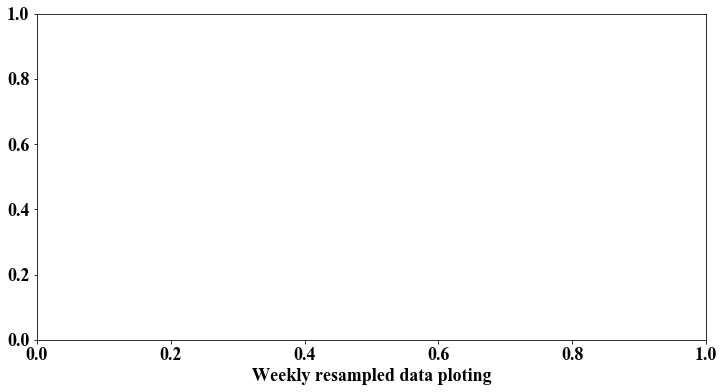

In [81]:
plt.figure(figsize=(12,6))
plt.xlabel('Weekly resampled data ploting')

ax1 = data2010.plot(color='blue', grid=True, label='2010')
ax2 = data2011.plot(color='red', grid=True, secondary_y=True, label='2011')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

NameError: name 'data2012' is not defined

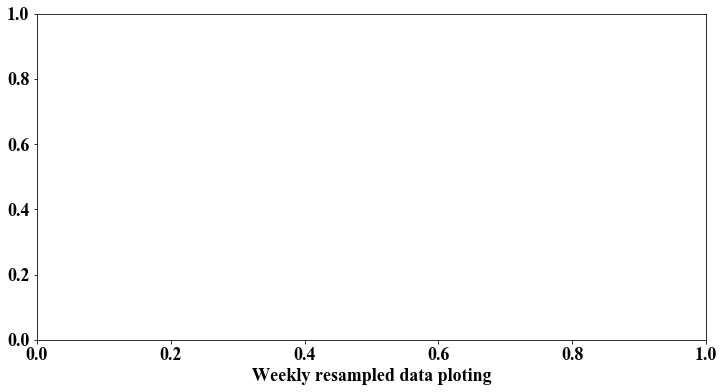

In [82]:
plt.figure(figsize=(12,6))
plt.xlabel('Weekly resampled data ploting')

ax1 = data2012.plot(color='blue', grid=True, label='2012')
ax2 = data2013.plot(color='red', grid=True, secondary_y=True, label='2013')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

In [ ]:
# create a boxplot of monthly data
dfTest=dfThesis.copy()
dfTest.head(1)

In [ ]:
dfTestT=dfTest.filter

In [ ]:
dfTest['per'] = dfThesis.index.to_period('M')
dfTest.boxplot(by='per')

NameError: name 'color' is not defined

<Figure size 1440x1152 with 0 Axes>

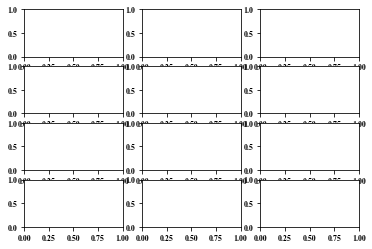

In [83]:
NewHourWiseMeanX=HourwiseMeanX.filter(['JanMean', 'FebMean', 'MarMean', 'AprMean','MayMean', 'JunMean', 'JulMean', 'AugMean','SepMean', 'OctMean','NovMean', 'DecMean'],axis=1)
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(20,16))
# styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
# ax = HourwiseMeanX.loc[:,'JanMean':'DecMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
# ax.set_ylabel('Electricity demand MW')
# ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=2)
# plt.xlabel('Half-hours')

fig2, axes = plt.subplots(nrows=4, ncols=3)
for i, ax in enumerate(axes.flatten()):
    NewHourWiseMeanX[NewHourWiseMeanX.columns[i]].plot(color=color, ax=ax)
    fig2.subplots_adjust(hspace=0.8)
    #fig2.subplots_adjust(vspace=0.5)
    ax.set_title(NewHourWiseMeanX.columns[i])
    
#     if i%3==0:
#         plt.ylabel('Load change per Celcius')
    if i%3>=1:
        ax.set_yticks([])
#     if i<=9:
#         ax.get_xlabel.remove()
#         #plt.xlabel([])
        

    #         if ii<=9:
#             ax.get_legend().remove()
#         if ii%3==0:
#             plt.ylabel('Load change per Celcius')

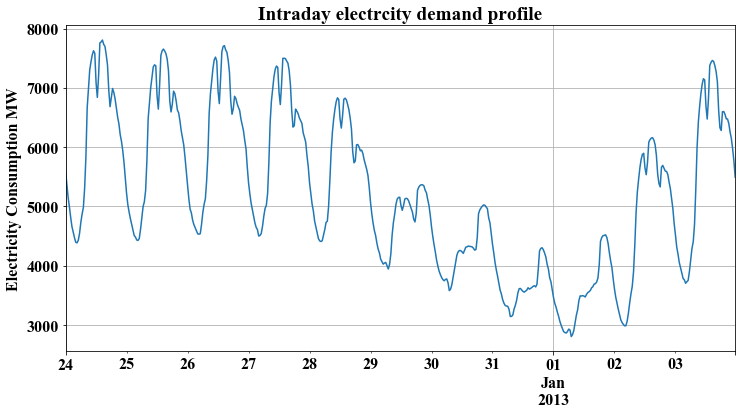

In [95]:
#dfThesis.loc['2009-3-2':'2009-3-15','Demand'].plot(title='Demand')
#plt.grid()
# fig = plt.figure()
# data.loc['2009-3-2','load'].plot(title='load')
# data.loc['2009-3-3','load'].plot()
# plt.grid()

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
dfThesis.loc['2012-12-24':'2013-01-3','Demand'].plot(title='Intraday electrcity demand profile')
plt.ylabel('Electricity Consumption MW')
plt.grid()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/MonToFriMean_ReligionMean.eps',dpi=400, format='eps')



In [96]:
ds=dfThesis.copy()

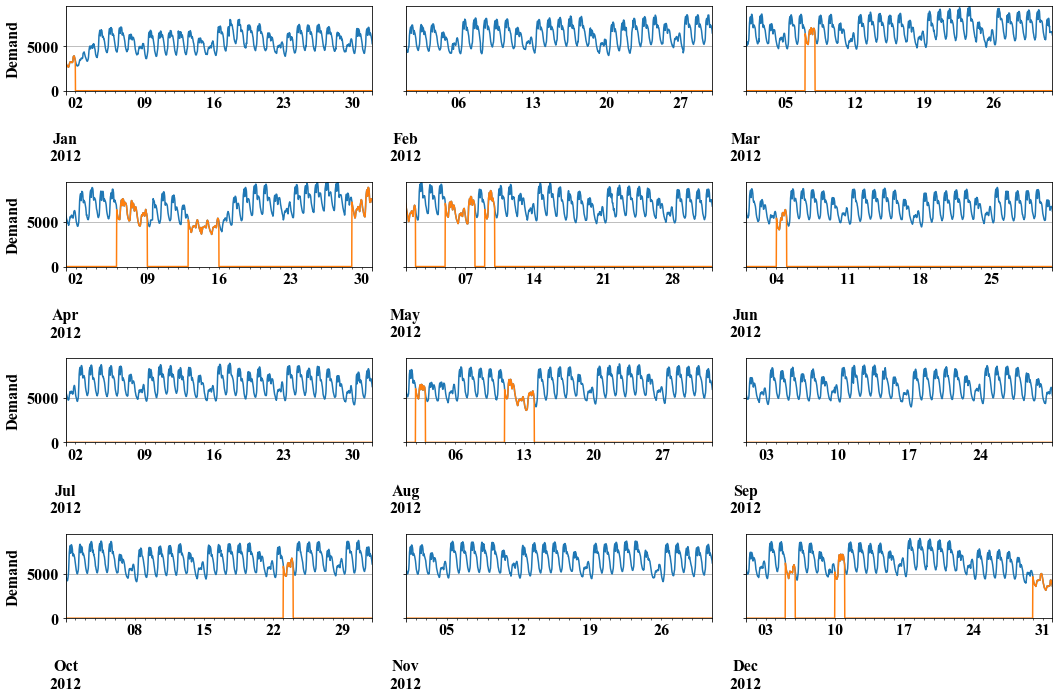

In [97]:
# Let's zoom in and look for the loads in each month
def monthlyplot(ds,yr,fa=3,fb=3):
    if (yr == 2009):
        fa=3
        mo = 4
    else:
        fa=4
        mo = 1
    fig, axes = plt.subplots(fa,fb,figsize=(15,10), sharey=True)
    for i in range(fa):
        for j in range(fb):
            tr = ('%d-%d' % (yr,mo))
            dfThesis.loc[tr, ds].plot(ax=axes[i,j], grid=True)
            if (ds=='Demand'):
                (dfThesis.loc[tr, ds]*dfThesis.loc[tr,'Holiday']).plot(ax=axes[i,j], grid=True)
            axes[i,j].set_ylabel(ds)
            mo = mo+1
            plt.ylim(0,9500)
    plt.tight_layout()

#monthlyplot(ds='Demand', yr=2009)
#monthlyplot(ds='Demand', yr=2010)
# monthlyplot(ds='Demand', yr=2011)
monthlyplot(ds='Demand', yr=2012)
# monthlyplot(ds='Demand', yr=2013)   
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/Year2012.eps', format='eps', dpi=400)

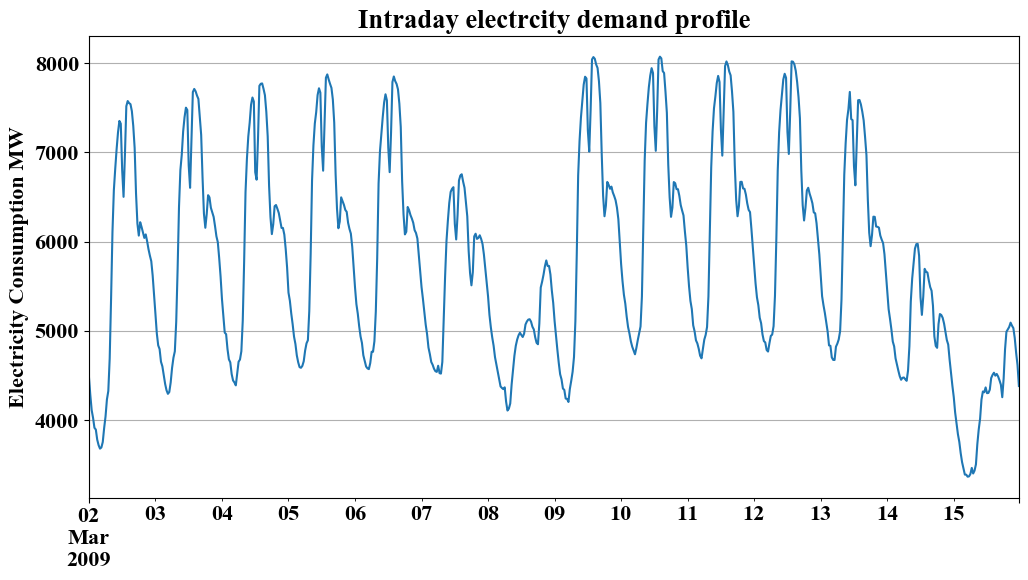

In [98]:
plt.style.use('default') #if plot is disturbed by sns.plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
dfThesis.loc['2009-3-2':'2009-3-15','Demand'].plot(title='Intraday electrcity demand profile')
plt.ylabel('Electricity Consumption MW')
plt.grid()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/MonToFriMean_ReligionMean.eps',dpi=400, format='eps')


In [ ]:
#Declare the array containing the series you want to plot. 
#For example:
# time_series_array = np.sin(np.linspace(-np.pi, np.pi, 400)) + np.random.rand((400))
# n_steps           = 15 #number of rolling steps for the mean/std.

# #Compute curves of interest:
# time_series_df = pd.DataFrame(time_series_array)
# smooth_path    = time_series_df.rolling(n_steps).mean()
# path_deviation = 2 * time_series_df.rolling(n_steps).std()

# under_line     = (smooth_path-path_deviation)[0]
# over_line      = (smooth_path+path_deviation)[0]

# #Plotting:
# plt.plot(smooth_path, linewidth=2) #mean curve.
# plt.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1) #std curves.

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
yr = 2013
# y = data[datetime(yr-1,12,22)+Week(-1,weekday=0):datetime(yr,1,8)+Week(0,weekday=0)]
y = dfThesis[datetime(yr,4,11)+Week(-1,weekday=0):datetime(yr,4,20)+Week(0,weekday=0)]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Demand', color=color)
ax1.plot(y.index, y.Demand, color=color, label='Demand')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Electricity demand (MW)')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)


#ax2.set_ylabel('Temperature ($^{\circ}C$)', color='b')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Songkran', color=color)
ax2.plot(y.index, y.HolidayLong, color=color, label='Songkran')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='upper center', bbox_to_anchor=(0.78, 0.45), fancybox=False, shadow=False, ncol=1)

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))

yr = 2012
y = dfThesis[datetime(yr-1,12,22)+Week(-1,weekday=0):datetime(yr,1,8)+Week(0,weekday=0)]
# y = data[datetime(yr,4,11)+Week(-1,weekday=0):datetime(yr,4,20)+Week(0,weekday=0)]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Demand', color=color)
ax1.plot(y.index, y.Demand, color=color, label='Demand')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Electricity demand (MW)')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('New Year', color=color)
ax2.plot(y.index, y.HolidayLong, color=color, label='New Year')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='upper center',bbox_to_anchor=(0.78, 0.45), fancybox=False, shadow=False, ncol=1)

In [ ]:
yr = 2011
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
y = dfThesis[datetime(yr,12,1)+Week(-1,weekday=0):datetime(yr+1,1,10)+Week(0,weekday=0)]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('load', color=color)
ax1.plot(y.index, y.Demand, color=color, label='Demand')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Electricity demand (MW)')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Long holiday', color=color)
ax2.plot(y.index, y.HolidayLong, color=color, label='Long holiday')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='upper center',bbox_to_anchor=(0.28, 0.45), fancybox=False, shadow=False, ncol=1)

x1 = '2011-12-31'
x2 = '2012-01-02'
# select y-range for zoomed region
y1 = 3000
y2 = 4000

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax1,4, loc=1) # zoom = 2
#ax1.plot(y.index, y.Demand, color=color, label='Demand')
axins.plot(y.index,y.Demand, color=color, label='Demand')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))

y = dfThesis['2010-10-1':'2011-2-28']
# plt.plot(y.index, y.Demand)
# #print(y.shape[0])
z = dfThesis['2011-10-1':'2012-2-28']
# #print(z.shape[0])
# plt.plot(y.index, z.Demand, color='red')
# plt.xticks(rotation=90)
# plt.grid()


#yr = 2011
#y = dfThesis[datetime(yr,12,1)+Week(-1,weekday=0):datetime(yr+1,1,10)+Week(0,weekday=0)]

fig, ax1= plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Demand', color=color)
ax1.plot(z.index, y.Demand, color=color, label='Demand:non-flooding ')
ax1.plot(z.index, z.Demand, color='b', label='Demand:flooding')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Electricity demand (MW)')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

fig.legend(loc='upper center',bbox_to_anchor=(0.38, 0.40), fancybox=False, shadow=False, ncol=1)
# props=dict(boxstyle='round', facecolor='blue', alpha=0.5)
# ax1.text(0.5,0.4,'Test',transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props) 
# x1 = '2011-10-15'
# x2 = '2012-01-15'
# # select y-range for zoomed region
# y1 = 5000
# y2 = 8000

# # Make the zoom-in plot:
# axins = zoomed_inset_axes(ax1,1, loc=1) # zoom = 2
# #ax1.plot(y.index, y.Demand, color=color, label='Demand')
# axins.plot(y.index,y.Demand, color=color, label='Demand')
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
# mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# plt.draw()
#plt.show()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ImageEps/FloodDemandDecrease.eps',dpi=400, format='eps')



In [ ]:
dfThesis.head(1)

In [ ]:
# dfThesisDemand=dfThesis.iloc[:,0:1]
# dfThesisDemand.head(1)
NewHourWiseMeanX

In [ ]:
NewHourWiseMeanX=NewHourWiseMeanX.rename(columns = {"JanMean":"Jan","FebMean":"Feb","MarMean":"Mar","AprMean":"Apr","MayMean":"May","JunMean":"Jun","JulMean":"Jul","AugMean":"Aug","SepMean":"Sep","OctMean":"Oct","NovMean":"Nov","DecMean":"Dec"})
NewHourWiseMeanX

In [ ]:
# dfThesisGroupHH=dfThesis.groupby('Weekday')
# dfThesisGroupHHX=dfThesisGroupHH.mean()
# dfThesisGroupHHdemand=dfThesisGroupHHX.iloc[:,0:2]
# dfThesisGroupHHdemand
# #dfThesisGroupHHX=dfThesisGroupHH.copy()


In [ ]:
NewHourWiseMeanX=NewHourWiseMeanX.rename(columns = {"JanMean":"Jan","FebMean":"Feb",\
                                                    "MarMean":"Mar","AprMean":"Apr",\
                                                    "MayMean":"May","JunMean":"Jun","JulMean":"Jul",\
                                                    "AugMean":"Aug","SepMean":"Sep",\
                                                    "OctMean":"Oct","NovMean":"Nov","DecMean":"Dec"})
NewHourWiseMeanXT=NewHourWiseMeanX.transpose()
NewHourWiseMeanX.head(1)

In [ ]:
NewHourWiseMeanX=NewHourWiseMeanX.rename(columns = {"JanMean":"Jan","FebMean":"Feb",\
                                                    "MarMean":"Mar","AprMean":"Apr",\
                                                    "MayMean":"May","JunMean":"Jun","JulMean":"Jul",\
                                                    "AugMean":"Aug","SepMean":"Sep",\
                                                    "OctMean":"Oct","NovMean":"Nov","DecMean":"Dec"})
NewHourWiseMeanXT=NewHourWiseMeanX.transpose()
NewHourWiseMeanXT.reset_index()
NewHourWiseMeanXT

In [94]:
#NewHourWiseMeanXT=NewHourWiseMeanXT.rename(columns = {"JanMean":"Jan","FebMean":"Feb","MarMean":"Mar","AprMean":"Apr","MayMean":"May","JunMean":"Jun","AugMean":"Aug","SepMean":"Sep","OctMean":"Oct","NovMean":"Nov","DecMean":"Dec"})
# yrs=['2010','2011','2012','2013']
# mth=['JanMean','FebMean','MarMean','AprMean','MayMean','JunMean','JulMean','AugMean','SepMean','OctMean','NovMean','DecMean']
# fa, fb = 2, 2
# fig, axes = plt.subplots(fa,fb,figsize=(15,15))
# for i in range (fa):
#     for j in range(fb):
#         NewHourWiseMeanX.loc[yrs[i],mth[i]].plot(ax=axes[i,j])  
plt.figure(figsize=(12,6))
mth=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
#ax = NewHourWiseMeanXT.loc[:,'2010':'2013'].plot(style=styles,grid=True,\
#                                                title='Electricity demand 2010-2013')
ax = NewHourWiseMeanXT.loc[:,'2010':'2013'].plot(style=styles,grid=True)

ax.set_ylabel('Electricity demand (MW)')
ax.set_xticklabels(mth,minor=True)


#ax.legend(bbox_to_anchor=(1.05, 1.0))



NameError: name 'NewHourWiseMeanXT' is not defined

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [ ]:
# fa, fb = 4, 3
# fig, axes = plt.subplots(fa,fb,figsize=(15,15))
# for i in range(fa):
#     for j in range(fb):
#         dfThesis.loc['2013-%d' % (fb*i+j+1), ['Demand']].plot(ax=axes[i,j])
# plt.tight_layout()

In [ ]:
fa, fb = 2, 2
fig, axes = plt.subplots(fa,fb,figsize=(15,15))
for i in range(fa):
    for j in range(fb):
        dfThesis.loc['2013-%d' % (fb*i+j+1), ['Demand']].plot(ax=axes[i,j])
plt.tight_layout()

In [ ]:

yrs=['2010','2011','2012','2013']
mth='-12'
Startd='-24'
endd='-31'
fa, fb = 2, 2
fig, axes = plt.subplots(fa,fb,figsize=(12,6))
cnt=0
for i in range (fa):
    for j in range(fb):
        dfThesis.loc[yrs[cnt]+mth+Startd:yrs[cnt]+mth+endd,['Demand']].plot(ax=axes[i,j])
        cnt=cnt+1
                  
plt.tight_layout()


In [ ]:
NewHourWiseMeanX

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
dfThesisDemandd=pd.DataFrame(dfThesis.Demand)
dfThesisDemandd['MA_336']=dfThesisDemandd.Demand.rolling(336).mean()
#dfThesisDemandd['MA_1485']=dfThesisDemandd.Demand.rolling(1485).mean()
#plt.figure(figsize=(15,10))
plt.grid(False)
plt.plot(dfThesisDemandd['Demand'], label='Demand',color='b', alpha=.1)
plt.plot(dfThesisDemandd['MA_336'], label='Rolling window 336')
plt.ylabel('Electricity demand (MW)')
plt.ylim(0,9900)
#plt.xlabel('Years')
#plt.plot(dfThesisDemandd['MA_1485'], label='Rolling window 1485')
plt.legend(loc=2)   
#plt.savefig(r'/Users/mac/Desktop/TUproject/Journal/EnergiesThaiJorn/ProofReadImage/RollingWindow336.eps', format='eps', dpi=400)


In [ ]:
#Actually temperature and demand relationship is already plotted, 
#this graphs are only for practice of resampling coding

# dfThesis.resample('D').sum()
# plt.dfThesis.loc(dfThesis.demand.resample('M'))

dfThesis_Daily=dfThesis.resample('D').mean() #getting daily data

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(dfThesis_Daily.index, dfThesis_Daily['Demand'], 'r-', label='Demand')
ax2.plot(dfThesis_Daily.index, dfThesis_Daily['Temp'], 'b-',label='Temperature')
ax1.legend(loc=0)
ax2.legend(loc=0)
ax1.set_xlabel('Years')
ax1.set_ylabel('Electricity demand (MW)', color='r')
ax2.set_ylabel('Temperature ($^{\circ}C$)', color='b')
#ax1,ax2.legend('Demand', 'Temp')
#plt.legend()#(bbox_to_anchor=(1.05, 1.0), ncol=2)
plt.show()
plt.rcParams['figure.figsize'] = 12,5

In [ ]:
# plt.dfThesis.loc(dfThesis.demand.resample('M'))

dfThesis_Daily=dfThesis.resample('M').mean() #getting daily data

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(dfThesis_Daily.index, dfThesis_Daily['Demand'], 'r-',label='Demand')
ax2.plot(dfThesis_Daily.index, dfThesis_Daily['Temp'], 'b-',label='Temperature')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('Years')
ax1.set_ylabel('Electricity demand (MW)', color='r')
ax2.set_ylabel('Temperature ($^{\circ}C$)', color='b')

plt.show()
plt.rcParams['figure.figsize'] = 12,5

In [ ]:
# plt.dfThesis.loc(dfThesis.demand.resample('M'))

dfThesis_Daily=dfThesis.resample('Y').mean() #getting daily data

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(dfThesis_Daily.index, dfThesis_Daily['Demand'], 'r-')
ax2.plot(dfThesis_Daily.index, dfThesis_Daily['Temp'], 'b-')

ax1.set_xlabel('Years')
ax1.set_ylabel('Electricity demand (MW)', color='r')
ax2.set_ylabel('Temperature ($^{\circ}C$)', color='b')

plt.show()
plt.rcParams['figure.figsize'] = 12,5

Text(0.5, 0, 'Half-hours')

<Figure size 1152x1152 with 0 Axes>

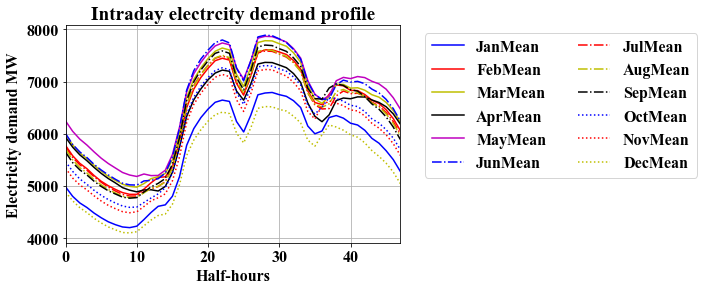

In [93]:
#getting Seasonal (Thai) plot,==>
#getting Monthly plot for different years,
#Now for Months and days, using resample..
Jan=dfThesis[(dfThesis.Month==1)]
Feb=dfThesis[(dfThesis.Month==2)]
Mar=dfThesis[(dfThesis.Month==3)]
Apr=dfThesis[(dfThesis.Month==4)]
May=dfThesis[(dfThesis.Month==5)]
Jun=dfThesis[(dfThesis.Month==6)]
Jul=dfThesis[(dfThesis.Month==7)]
Aug=dfThesis[(dfThesis.Month==8)]
Sep=dfThesis[(dfThesis.Month==9)]
Oct=dfThesis[(dfThesis.Month==10)]
Nov=dfThesis[(dfThesis.Month==11)]
Dec=dfThesis[(dfThesis.Month==12)]

#Groupby function is the best for this purpose..
JanHH=Jan.groupby('HH')
FebHH=Feb.groupby('HH')
MarHH=Mar.groupby('HH')
AprHH=Apr.groupby('HH')
MayHH=May.groupby('HH')
JunHH=Jun.groupby('HH')
JulHH=Jul.groupby('HH')
AugHH=Aug.groupby('HH')
SepHH=Sep.groupby('HH')
OctHH=Oct.groupby('HH')
NovHH=Nov.groupby('HH')
DecHH=Dec.groupby('HH')

#Hourwise mean
JanMean=JanHH.mean()
FebMean=FebHH.mean()
MarMean=MarHH.mean()
AprMean=AprHH.mean()
MayMean=MayHH.mean()
JunMean=JunHH.mean()
JulMean=JulHH.mean()
AugMean=AugHH.mean()
SepMean=SepHH.mean()
OctMean=OctHH.mean()
NovMean=NovHH.mean()
DecMean=DecHH.mean()




#Creating new dataframe for hh=0 to 47
HourwiseMeanX=JanMean.copy()
HourwiseMeanX['JanMean']=JanMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['FebMean']=FebMean.loc[:,'Demand']
HourwiseMeanX['MarMean']=MarMean.loc[:,'Demand']
HourwiseMeanX['AprMean']=AprMean.loc[:,'Demand']
HourwiseMeanX['MayMean']=MayMean.loc[:,'Demand']
HourwiseMeanX['JunMean']=JunMean.loc[:,'Demand']
HourwiseMeanX['JulMean']=JulMean.loc[:,'Demand']
HourwiseMeanX['AugMean']=AugMean.loc[:,'Demand']
HourwiseMeanX['SepMean']=SepMean.loc[:,'Demand']
HourwiseMeanX['OctMean']=OctMean.loc[:,'Demand']
HourwiseMeanX['NovMean']=NovMean.loc[:,'Demand']
HourwiseMeanX['DecMean']=DecMean.loc[:,'Demand']

# plt.rcParams.update({'font.size': 18})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.figure(figsize=(12,6))
# HourwiseMeanX.loc[:,'MonToFriMean'].plot(title='Intraday electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plt.grid()

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(16,16))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,'JanMean':'DecMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand MW')
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=2)
plt.xlabel('Half-hours')



In [ ]:
#lets delete del previously constructed df HourwiseMeanX
del HourwiseMeanX
#Now start again,





Sun=dfThesis[(dfThesis.Weekday==6)]
Mon=dfThesis[(dfThesis.Weekday==0)]
Tue=dfThesis[(dfThesis.Weekday==1)]
Wed=dfThesis[(dfThesis.Weekday==2)]
Thu=dfThesis[(dfThesis.Weekday==3)]
Fri=dfThesis[(dfThesis.Weekday==4)]
Sat=dfThesis[(dfThesis.Weekday==5)]

#Groupby function is the best for this purpose..
SunHH=Sun.groupby('HH')
MonHH=Mon.groupby('HH')
TueHH=Tue.groupby('HH')
WedHH=Wed.groupby('HH')
ThuHH=Thu.groupby('HH')
FriHH=Fri.groupby('HH')
SatHH=Sat.groupby('HH')

#Hourwise mean
SunMean=SunHH.mean()
MonMean=MonHH.mean()
TueMean=TueHH.mean()
WedMean=WedHH.mean()
ThuMean=ThuHH.mean()
FriMean=FriHH.mean()
SatMean=SatHH.mean()

#Creating new dataframe for hh=0 to 47
HourwiseMeanX=SunMean.copy()
HourwiseMeanX['SunMean']=SunMean.loc[:,'Demand']
#Storing in dataframe,
#HourwiseMeanX['MonToFriMean']=MonToFriMean.loc[:,'Demand']
HourwiseMeanX['MonMean']=MonMean.loc[:,'Demand']
HourwiseMeanX['TueMean']=TueMean.loc[:,'Demand']
HourwiseMeanX['WedMean']=WedMean.loc[:,'Demand']
HourwiseMeanX['ThuMean']=ThuMean.loc[:,'Demand']
HourwiseMeanX['FriMean']=FriMean.loc[:,'Demand']
HourwiseMeanX['SatMean']=SatMean.loc[:,'Demand']

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-','r-','y-','k-','m-','b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,'SunMean':'SatMean'].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand MW')
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('Half-hours')

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
styles=['b-.','r-.','y-.','k-.','b:','r:','y:','k:']
ax = HourwiseMeanX.loc[:,['SunMean','SatMean']].plot(style=styles,grid=True,title='Intraday electrcity demand profile')
ax.set_ylabel('Electricity demand MW')
#ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('Half-hours')

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
data.loc['2009-3-2':'2009-3-10','load'].plot(title='Illustration of sliding window')
plt.ylabel('Electricity Consumption MW')
plt.grid(False)


In [ ]:
# create some data to use for the plot
# dt = 0.001
# t = np.arange(0.0, 10.0, dt)
# r = np.exp(-t[:1000]/0.05)               # impulse response
# x = np.random.randn(len(t))
# s = np.convolve(x, r)[:len(x)]*dt  # colored noise

# the main axes is subplot(111) by default
#plt.plot(t, s)
ts=data.loc['2009-4-1':'2009-4-30','load']
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Gaussian colored noise')

# this is an inset axes over the main axes
a = plt.axes([.65, .6, .2, .2], facecolor='y')
n, bins, patches = plt.hist(s, 400, normed=1)
plt.title('Probability')
plt.xticks([])
plt.yticks([])

# this is another inset axes over the main axes
a = plt.axes([0.2, 0.6, .2, .2], facecolor='y')
plt.plot(t[:len(r)], r)
plt.title('Impulse response')
plt.xlim(0, 0.2)
plt.xticks([])
plt.yticks([])

plt.show()








In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#data.loc['2009-3-2':'2009-3-15','load'].plot(title='Intraday electrcity demand profile')

ts=data.loc['2009-4-1':'2009-4-30','load']

#ts=dfThesis.Demand
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()
ax.set_xlabel('Years')
ax.set_ylabel('Electricity Demand')
ax.plot(ts)

#I want to select the x-range for the zoomed region. I have figured it out suitable values
# by trial and error. How can I pass more elegantly the dates as something like
x1 = '2009-4-9'
x2 = '2009-4-10'
# select y-range for zoomed region
y1 = 6000
y2 = 8000

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax,3, loc=1) # zoom = 2
axins.plot(ts)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


NameError: name 'zoomed_inset_axes' is not defined

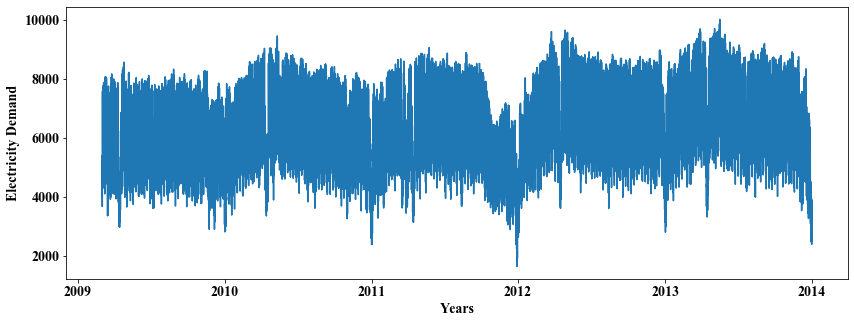

In [92]:
ts=dfThesis.Demand
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()
ax.set_xlabel('Years')
ax.set_ylabel('Electricity Demand')
ax.plot(ts)

#I want to select the x-range for the zoomed region. I have figured it out suitable values
# by trial and error. How can I pass more elegantly the dates as something like
x1 = '2011-10-01'
x2 = '2012-03-05'
# select y-range for zoomed region
y1 = 1500
y2 = 9000

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax,1, loc=1) # zoom = 2
axins.plot(ts)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()

In [ ]:
# Label the axis


# select y-range for zoomed region
y1 = 6000
y2 = 7000

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax, 500, loc=1) # zoom = 2
axins.plot(ts)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


In [ ]:
# create some data to use for the plot
dt = 0.001
t = np.arange(0.0, 10.0, dt)
r = np.exp(-t[:1000]/0.05)               # impulse response
x = np.random.randn(len(t))
s = np.convolve(x, r)[:len(x)]*dt  # colored noise

# the main axes is subplot(111) by default
plt.plot(t, s)
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Gaussian colored noise')

# this is an inset axes over the main axes
a = plt.axes([.65, .6, .2, .2], facecolor='y')
n, bins, patches = plt.hist(s, 400, normed=1)
plt.title('Probability')
plt.xticks([])
plt.yticks([])

# this is another inset axes over the main axes
a = plt.axes([0.2, 0.6, .2, .2], facecolor='y')
plt.plot(t[:len(r)], r)
plt.title('Impulse response')
plt.xlim(0, 0.2)
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
#Groupby function is the best for this purpose..
Hourwise=dfThesis.groupby('HH')
HourwiseMean=Hourwise.mean()
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
HourwiseMeanX['HourwiseMean']=HourwiseMean.loc[:,'Demand']
HourwiseMean.loc[:,'Demand'].plot(title='Intraday electrcity demand profile')
plt.ylabel('Electricity Consumption MW')
plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


# Some works for figure plotting

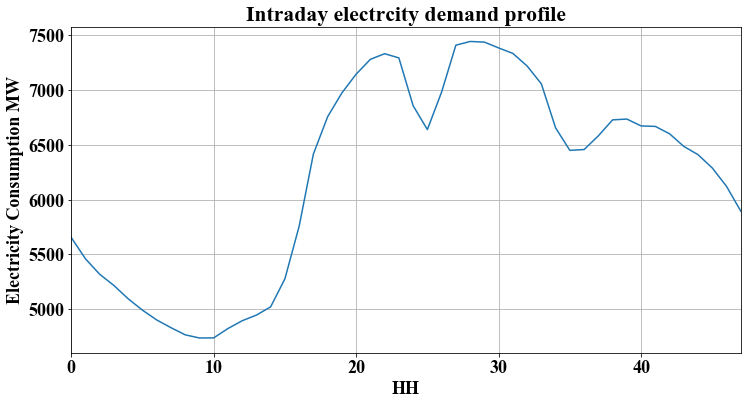

In [84]:
#Groupby function is the best for this purpose..
Hourwise=dfThesis.groupby('HH')
HourwiseMean=Hourwise.mean()
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
HourwiseMeanX['HourwiseMean']=HourwiseMean.loc[:,'Demand']
HourwiseMean.loc[:,'Demand'].plot(title='Intraday electrcity demand profile')
plt.ylabel('Electricity Consumption MW')
plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


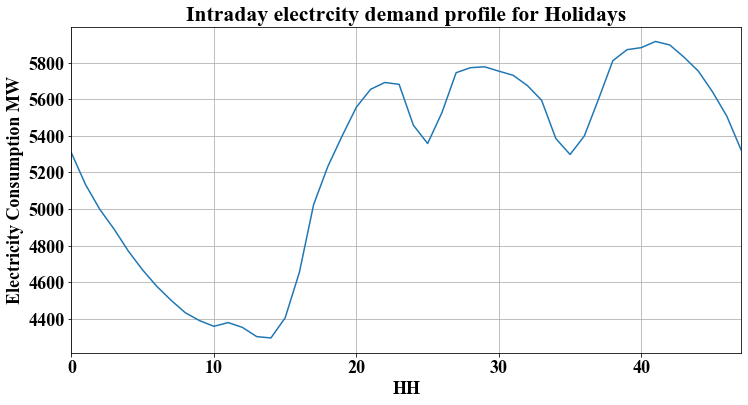

In [85]:
DataHoliday=dfThesis[(dfThesis.Holiday==1)]  #['2011-1']

HourwiseDataHoliday=DataHoliday.groupby('HH')
HourwiseMeanDataHoliday=HourwiseDataHoliday.mean()
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
HourwiseMeanX['HourwiseMeanHoliday']=HourwiseMeanDataHoliday.loc[:,'Demand']
HourwiseMeanDataHoliday.loc[:,'Demand'].plot(title='Intraday electrcity demand profile for Holidays')
plt.ylabel('Electricity Consumption MW')
plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


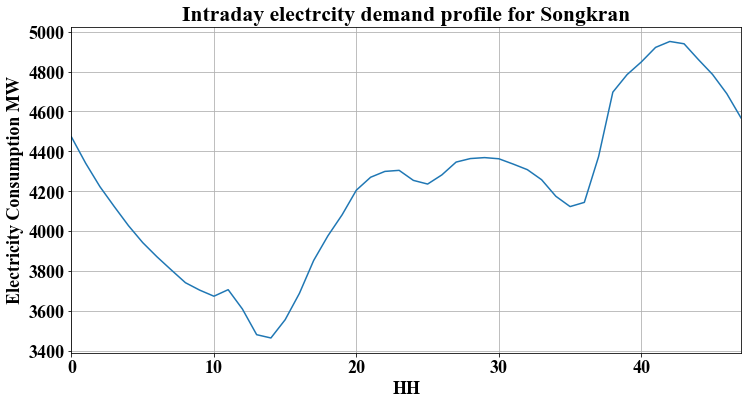

In [86]:
DataSongkran=dfThesis[(dfThesis.Songkran==1)]  # sorting the data only from Songkran
HourwiseDataSongkran=DataSongkran.groupby('HH') # grouping based on HH
HourwiseMeanDataSongkran=HourwiseDataSongkran.mean() #getting mean for all HH
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12,6))
HourwiseMeanX['HourwiseMeanSongkran']=HourwiseMeanDataSongkran.loc[:,'Demand']
HourwiseMeanDataSongkran.loc[:,'Demand'].plot(title='Intraday electrcity demand profile for Songkran')
plt.ylabel('Electricity Consumption MW')
plt.grid()
# plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand.eps',dpi=200, format='eps')


In [ ]:
T=48
Search_start='2009-1-1'
Search_end='2013-12-31'
Search = dfThesis[Search_start:Search_end ]
Search_size = int(Search.shape[0]/T)
print('Sizes: Search =%d' % (Search_size))

In [ ]:
#p=dfThesis.resample('D', how='sum')
Summer2010=dfThesis.loc['2013-01-01':'2013-12-31','Demand'].resample('D').sum()
Summer2010

In [ ]:
dfHoliday = list()

In [91]:
df['load_pred'] = 0
df['load_fitted'] = 0
model_param = list()

T=48
for hh in range(T):
    predictions = list()
    obs = list()

    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh])
    y = np.asarray(y0)
    X = np.asarray(X0)
    
    for t in range(test_size):
        hh_train_start = t
        hh_train_end = t + train_size
        hh_test = hh_train_end
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test]
        Xtest = X[hh_test]
        
        model = sm.OLS(ytrain, Xtrain)
        model_fit = model.fit(disp=0)

        output = model_fit.predict(Xtest)
        yhat = output[0]
#         yhat = np.dot(model_fit.params, Xtest)
#         print('t=%d, predicted=%.0f, expected=%.0f' % (t,yhat, ytest))
        predictions.append(yhat)
        obs.append(ytest)

    print('hh=%d' % hh)
    print((model_fit.summary()))
    df.loc[(df.Year == 2013) & (df.HH==hh),'load_pred'] = predictions
    model_param.append(model_fit.params)

AttributeError: 'DataFrame' object has no attribute 'HH'

In [ ]:
Summer2010=dfThesis.loc['2013-01-01':'2013-12-31','Demand'].resample('30min').sum()
Summer2010.describe()

In [ ]:
#year_hour_means = dfThesis.resample('30min',how = 'mean')
#year_hour_means

In [ ]:
Summer2010=dfThesis.loc['2010-03':'2010-05','Demand'].resample('30min').sum()
Summer2010.head(1)

In [ ]:
Summer2010=dfThesis.resample('30min')['Demand']. mean()
Summer2010.head()

In [ ]:
plt.figure()
t0 = '-3'; t1 = '-5'
ind = data['2009'+t0:'2009'+t1].index
yrs = ['2010', '2011', '2012', '2013']
fig, axes = plt.subplots(1,2,figsize=(10,5))
for yr in yrs:
    axes[1].plot(ind, data.loc[yr+t0:yr+t1,'load'],label=yr)
    #axes[0].plot(ind, data.loc[yr+t0:yr+t1,'temp'],label=yr)
for ax in fig.axes:
    ax.grid()
    ax.legend()
    plt.xticks(rotation=90)

In [ ]:
# SEASON CONDITIONAL CALCULATION
dfThesis['Season'] = np.where(dfThesis['Month'].isin([1,11,12]), 'Winter',
                        np.where(dfThesis['Month'].isin([3,4,5]), 'Summer',
                                 np.where(dfThesis['Month'].isin([6,7,8]), 'Monsoon', None)))


In [ ]:
dfThesis.head(1)

In [ ]:
# dfThesisSeason=dfThesis.loc[:,['Demand','Temp', 'Year','Month','Day','Hour','HH','Season']]
# dfThesisSeason.head()
# dfThesisSeason.to_csv("dfThesisSeason.csv")
# dfThesisSeason.to_excel("dfThesisSeason.xlsx")

In [ ]:
# SummerDemandHH0=dfThesisSeason.query('HH==0 & Year==2010').loc[:,['Demand']].mean()


In [ ]:
# dfThesisSeason1=dfThesis.loc[:,['Demand']]
# dfThesisSeason1.head(1)

In [ ]:
yrs = ['2010', '2011', '2012', '2013']
for yr in yrs:
    

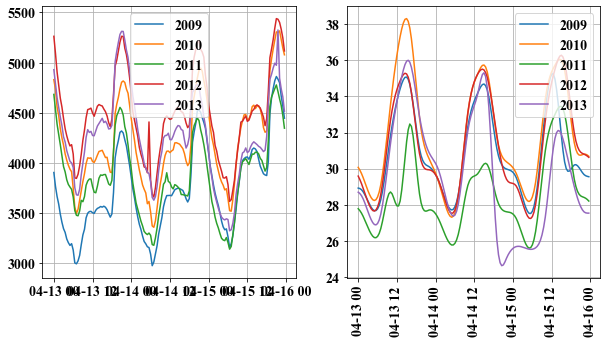

In [90]:
yrs = ['2009', '2010', '2011', '2012', '2013']
fig, axes = plt.subplots(1,2,figsize=(10,5))
for yr in yrs:
    axes[0].plot(ind, data.loc[yr+t0:yr+t1,'load'],label=yr)
    axes[1].plot(ind, data.loc[yr+t0:yr+t1,'temp'],label=yr)
for ax in fig.axes:
    ax.grid()
    ax.legend()
    plt.xticks(rotation=90)

In [89]:
dfSummer=df[(df.Season=='Summer')]

dfSummer.loc['2010':'2010','Demand'].plot(title='Intraday demand profile during Summer')

AttributeError: 'DataFrame' object has no attribute 'Season'

In [ ]:
#For Half-hourwise
Summer2010Demand=df.query('Month==1 & Holiday2==0').loc[:,['mape']].mean()
FebMape=MapeSc4.query('Month==2 & Holiday2==0').loc[:,['mape']].mean()
MarMape=MapeSc4.query('Month==3 & Holiday2==0').loc[:,['mape']].mean()
AprMape=MapeSc4.query('Month==4 & Holiday2==0').loc[:,['mape']].mean()
MayMape=MapeSc4.query('Month==5 & Holiday2==0').loc[:,['mape']].mean()
JunMape=MapeSc4.query('Month==6 & Holiday2==0').loc[:,['mape']].mean()
JulMape=MapeSc4.query('Month==7 & Holiday2==0').loc[:,['mape']].mean()
AugMape=MapeSc4.query('Month==8 & Holiday2==0').loc[:,['mape']].mean()
SepMape=MapeSc4.query('Month==9 & Holiday2==0').loc[:,['mape']].mean()
OctMape=MapeSc4.query('Month==10 & Holiday2==0').loc[:,['mape']].mean()
NovMape=MapeSc4.query('Month==11 & Holiday2==0').loc[:,['mape']].mean()
DecMape=MapeSc4.query('Month==12 & Holiday2==0').loc[:,['mape']].mean()

dict={'Jan':JanMape,'Feb':FebMape,'Mar':MarMape,'Apr':AprMape,'May':MayMape,\
      'Jun':JunMape,'Jul':JulMape,'Aug':AugMape,'Sep':SepMape,'Oct':OctMape,\
      'Nov':NovMape,'Dec':DecMape}
MAPEs = pd.DataFrame(dict)
MAPEs

In [ ]:
#For daywise
JanMape=MapeSc4.query('Month==1 & Holiday2==0').loc[:,['mape']].mean()
FebMape=MapeSc4.query('Month==2 & Holiday2==0').loc[:,['mape']].mean()
MarMape=MapeSc4.query('Month==3 & Holiday2==0').loc[:,['mape']].mean()
AprMape=MapeSc4.query('Month==4 & Holiday2==0').loc[:,['mape']].mean()
MayMape=MapeSc4.query('Month==5 & Holiday2==0').loc[:,['mape']].mean()
JunMape=MapeSc4.query('Month==6 & Holiday2==0').loc[:,['mape']].mean()
JulMape=MapeSc4.query('Month==7 & Holiday2==0').loc[:,['mape']].mean()
AugMape=MapeSc4.query('Month==8 & Holiday2==0').loc[:,['mape']].mean()
SepMape=MapeSc4.query('Month==9 & Holiday2==0').loc[:,['mape']].mean()
OctMape=MapeSc4.query('Month==10 & Holiday2==0').loc[:,['mape']].mean()
NovMape=MapeSc4.query('Month==11 & Holiday2==0').loc[:,['mape']].mean()
DecMape=MapeSc4.query('Month==12 & Holiday2==0').loc[:,['mape']].mean()

dict={'Jan':JanMape,'Feb':FebMape,'Mar':MarMape,'Apr':AprMape,'May':MayMape,\
      'Jun':JunMape,'Jul':JulMape,'Aug':AugMape,'Sep':SepMape,'Oct':OctMape,\
      'Nov':NovMape,'Dec':DecMape}
MAPEs = pd.DataFrame(dict)
MAPEs

<Figure size 432x288 with 0 Axes>

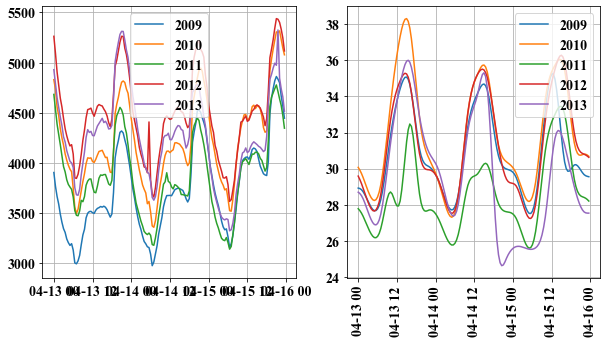

In [88]:
plt.figure()
t0 = '-4-13'; t1 = '-4-15'
ind = data['2009'+t0:'2009'+t1].index
yrs = ['2009', '2010', '2011', '2012', '2013']
fig, axes = plt.subplots(1,2,figsize=(10,5))
for yr in yrs:
    axes[0].plot(ind, data.loc[yr+t0:yr+t1,'load'],label=yr)
    axes[1].plot(ind, data.loc[yr+t0:yr+t1,'temp'],label=yr)
for ax in fig.axes:
    ax.grid()
    ax.legend()
    plt.xticks(rotation=90)

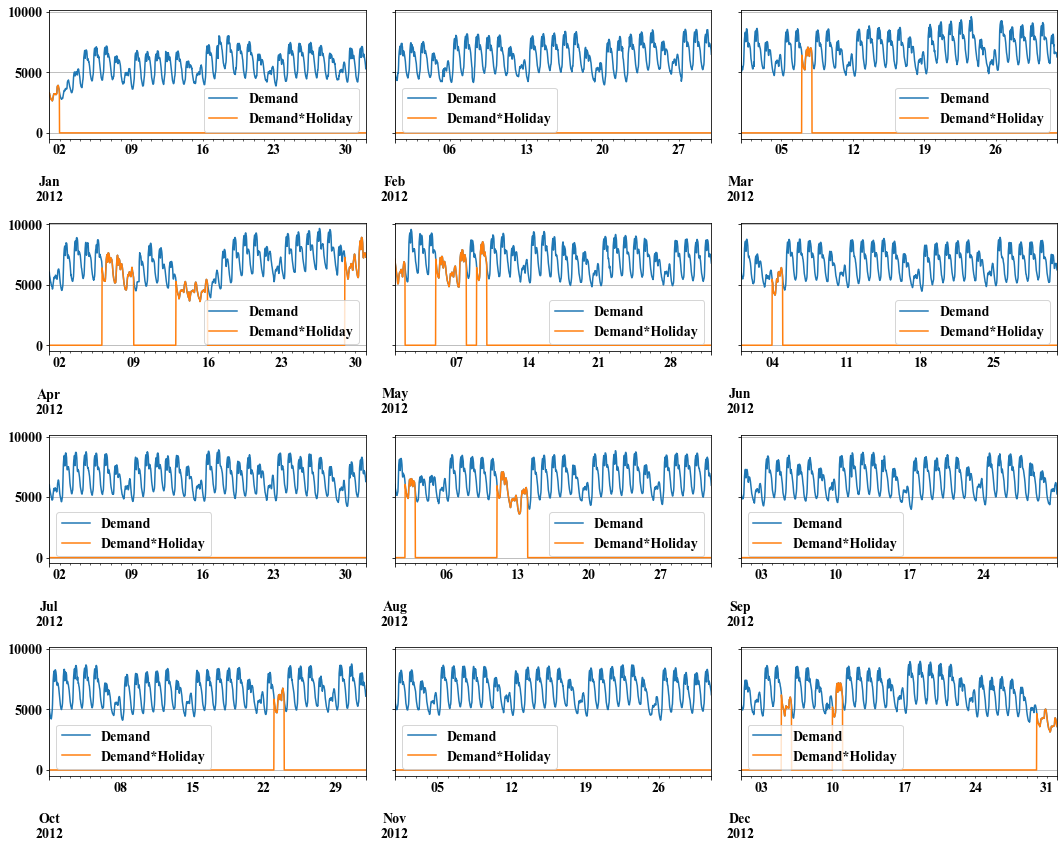

In [87]:
# df = data.loc[:,['load','Holiday']].copy()
# df['load*Holiday'] = df.load * df.Holiday
# #plt.plot(title='Half-hourly electrcity demand profile')
# plt.ylabel('Electricity Consumption MW')
# plotgroups(df.loc['2012':'2013',['load','load*Holiday']].resample('M'))
# plt.grid()
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand2012.eps',dpi=200, format='eps')
df = data.loc[:,['load','Holiday']].copy()
df = df.rename(columns = {"load": "Demand"}) 
df['Demand*Holiday'] = df.Demand * df.Holiday
plotgroups(df.loc['2012':'2012',['Demand','Demand*Holiday']].resample('M'))
#plt.savefig(r'/Users/mac/Desktop/TUproject/Programs/ThesisImage/IntradayDemand2012.eps',dpi=200, format='eps')